# This notebook plots lifetime-representative MCS properties for multiple trackers¶
## The MCS track statistics data is produced by:
- /src/make_mcs_stats_from_maskfile.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import warnings
%matplotlib inline

In [2]:
xr.__version__

'2023.5.0'

In [3]:
PHASE = 'Summer'
# PHASE = 'Winter'

lifetime_bounds = [2,80]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_DL = f'{rootdir}DL/'
dir_KFyAO = f'{rootdir}KFyAO/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        # 'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        # 'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_tobac = {key:f'{dir_tobac}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TAMS = {key:f'{dir_TAMS}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_simpleTrack = {key:f'{dir_simpleTrack}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_DL = {key:f'{dir_DL}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_KFyAO = {key:f'{dir_KFyAO}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [4]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SCREAMv1.nc: True


In [5]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SCREAMv1.nc: True


In [6]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SCREAMv1.nc: True


In [7]:
for key, value in filenames_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SCREAMv1.nc: True


In [8]:
for key, value in filenames_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SCREAMv1.nc: True


In [9]:
for key, value in filenames_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SCREAMv1.nc: True


In [10]:
for key, value in filenames_DL.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_SCREAMv1.nc: True


In [11]:
for key, value in filenames_KFyAO.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_SCREAMv1.nc: True


## Show a map for the subset region

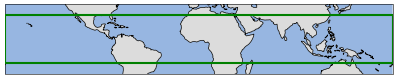

In [12]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [13]:
# Read a sample data
ds_tmp = xr.open_dataset(filenames_PyFLEXTRKR['obs'])

# Get global attributes (assume the same for all data)
pixel_radius = ds_tmp.attrs['pixel_radius_km']
time_resolution = ds_tmp.attrs['time_resolution_hour']

# Convert lifetime bounds (hour) to track duration bounds
duration_bounds = (lifetime_bounds / time_resolution).astype(int)
duration_max = max(duration_bounds)

In [14]:
# xr.open_dataset(filenames_PyFLEXTRKR['obs']).isel({'times':slice(0,duration_max), 'nmaxpf':0})
# ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source').isel({'times':})

In [15]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_pyflex = ds_pyflex.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
ds_pyflex

<xarray.Dataset>
Dimensions:                  (tracks: 5016, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5012 5013 5014 5015
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5016), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 80), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 15:28:20 2023

In [16]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_moaap = ds_moaap.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:                  (tracks: 5142, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5138 5139 5140 5141
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5142), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5142), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5142), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                MOAAP
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Apr 24 12:09:28 2024

In [17]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_toocan = ds_toocan.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
ds_toocan

<xarray.Dataset>
Dimensions:                  (tracks: 45171, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 277349 277396 278054
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 45171), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 45171), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 45171), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TOOCAN
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Nov  3 15:47:04 2023

In [18]:
# Read all files and combine them with a new dimension 'source'
ds_tobac = xr.open_mfdataset(list(filenames_tobac.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_tobac = ds_tobac.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_tobac['source'] = list(name_map.keys())
ds_tobac

<xarray.Dataset>
Dimensions:                  (tracks: 36332, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 2 3 6 ... 126662 126718 126729
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 36332), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 36332), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 36332), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                tobac
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri May  3 20:38:43 2024

In [19]:
# Read all files and combine them with a new dimension 'source'
ds_tams = xr.open_mfdataset(list(filenames_TAMS.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_tams = ds_tams.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_tams['source'] = list(name_map.keys())
ds_tams

<xarray.Dataset>
Dimensions:                  (tracks: 4575, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4571 4572 4573 4574
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4575), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4575), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4575), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TAMS
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Dec 27 14:40:15 2023

In [20]:
# Read all files and combine them with a new dimension 'source'
ds_simtrack = xr.open_mfdataset(list(filenames_simpleTrack.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_simtrack = ds_simtrack.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_simtrack['source'] = list(name_map.keys())
ds_simtrack

<xarray.Dataset>
Dimensions:                  (tracks: 22919, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 442211 442501 444390
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 22919), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 22919), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 22919), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                simpleTrack
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Jan  3 19:43:58 2024

In [21]:
# Read all files and combine them with a new dimension 'source'
ds_dl = xr.open_mfdataset(list(filenames_DL.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_dl = ds_dl.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_dl['source'] = list(name_map.keys())
ds_dl

<xarray.Dataset>
Dimensions:                  (tracks: 12624, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 20339 20358 20361 20367
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 12624), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 12624), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 12624), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 12624, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                DL
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Jun 10 12:24:28 2024

In [22]:
# Read all files and combine them with a new dimension 'source'
ds_kfyao = xr.open_mfdataset(list(filenames_KFyAO.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Rechunk DataSet (contiguous in tracks & times dimension, chunk in source dimension)
# ds_kfyao = ds_kfyao.chunk({'tracks':-1, 'times':-1, 'source':1})
# Assign new coordinate 'source' using name_map dictionary keys
ds_kfyao['source'] = list(name_map.keys())
ds_kfyao

<xarray.Dataset>
Dimensions:                  (tracks: 4691, times: 80, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4687 4688 4689 4690
  * times                    (times) int64 0 1 2 3 4 5 6 ... 74 75 76 77 78 79
    nmaxpf                   int64 0
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4691), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4691), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4691), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 80), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                KFyAO
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon May 20 12:24:56 2024

In [23]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2016-08-10', '2016-09-11'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-15, 30],
 [2, 80])

In [24]:
ds_pyflex.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Mon Oct 23 15:28:20 2023'}

In [25]:
# # Get global attributes
# pixel_radius = ds_pyflex.attrs['pixel_radius_km']
# time_resolution = ds_pyflex.attrs['time_resolution_hour']

In [26]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [27]:
dss_pyflex = find_tracks_start(ds_pyflex, load_data=False)

In [28]:
dss_moaap = find_tracks_start(ds_moaap, load_data=False)

In [29]:
dss_toocan = find_tracks_start(ds_toocan, load_data=False)

In [30]:
dss_tobac = find_tracks_start(ds_tobac, load_data=False)

In [31]:
dss_tams = find_tracks_start(ds_tams, load_data=False)

In [32]:
dss_simtrack = find_tracks_start(ds_simtrack, load_data=False)

In [33]:
dss_dl = find_tracks_start(ds_dl, load_data=False)

In [34]:
dss_kfyao = find_tracks_start(ds_kfyao, load_data=False)

In [35]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 2514
ARPEGE: 772
IFS: 2406
MPAS: 1192
NICAM: 2769
SAM: 2631
UM: 1586
FV3: 2049
SCREAMv1: 2691


In [36]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 2644
ARPEGE: 537
IFS: 2750
MPAS: 1386
NICAM: 2149
SAM: 2227
UM: 1866
FV3: 2178
SCREAMv1: 2843


In [37]:
print(f'Number of MCS (TOOCAN)')
for key in dss_toocan['source'].data:
    ntracks = np.count_nonzero(dss_toocan.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TOOCAN)
OBS: 3830
ARPEGE: 608
IFS: 4758
MPAS: 1276
NICAM: 3745
SAM: 2451
UM: 2190
FV3: 3063
SCREAMv1: 5316


In [38]:
print(f'Number of MCS (tobac)')
for key in dss_tobac['source'].data:
    ntracks = np.count_nonzero(dss_tobac.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (tobac)
OBS: 3069
ARPEGE: 1037
IFS: 4023
MPAS: 1234
NICAM: 4309
SAM: 3627
UM: 2541
FV3: 3017
SCREAMv1: 4001


In [39]:
print(f'Number of MCS (TAMS)')
for key in dss_tams['source'].data:
    ntracks = np.count_nonzero(dss_tams.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TAMS)
OBS: 2090
ARPEGE: 888
IFS: 2762
MPAS: 794
NICAM: 2429
SAM: 3401
UM: 1664
FV3: 2377
SCREAMv1: 2835


In [40]:
print(f'Number of MCS (simpleTrack)')
for key in dss_simtrack['source'].data:
    ntracks = np.count_nonzero(dss_simtrack.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (simpleTrack)
OBS: 2399
ARPEGE: 1022
IFS: 2577
MPAS: 989
NICAM: 2588
SAM: 3053
UM: 1458
FV3: 2249
SCREAMv1: 2616


In [41]:
print(f'Number of MCS (DL)')
for key in dss_dl['source'].data:
    ntracks = np.count_nonzero(dss_dl.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (DL)
OBS: 1618
ARPEGE: 995
IFS: 1912
MPAS: 504
NICAM: 1649
SAM: 2302
UM: 1224
FV3: 1770
SCREAMv1: 2075


In [42]:
print(f'Number of MCS (KFyAO)')
for key in dss_kfyao['source'].data:
    ntracks = np.count_nonzero(dss_kfyao.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (KFyAO)
OBS: 2023
ARPEGE: 809
IFS: 2502
MPAS: 1007
NICAM: 2364
SAM: 2805
UM: 1491
FV3: 2074
SCREAMv1: 2682


## Separate land vs. ocean MCS

In [43]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex)

In [44]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap)

In [45]:
dss_toocan_l, dss_toocan_o = get_land_ocean_ds(dss_toocan)

In [46]:
dss_tobac_l, dss_tobac_o = get_land_ocean_ds(dss_tobac)

In [47]:
dss_tams_l, dss_tams_o = get_land_ocean_ds(dss_tams)

In [48]:
dss_simtrack_l, dss_simtrack_o = get_land_ocean_ds(dss_simtrack)

In [49]:
dss_dl_l, dss_dl_o = get_land_ocean_ds(dss_dl)

In [50]:
dss_kfyao_l, dss_kfyao_o = get_land_ocean_ds(dss_kfyao)

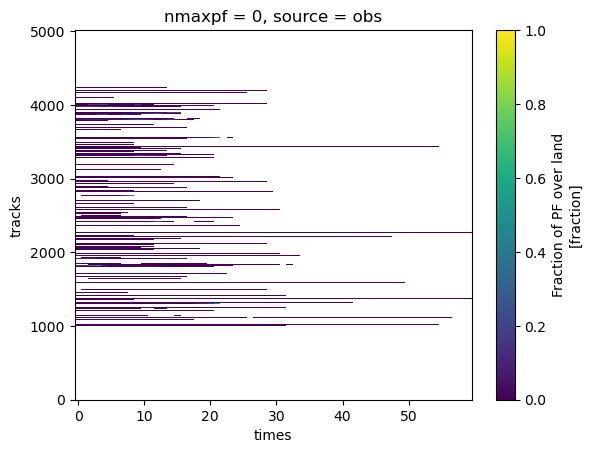

In [51]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

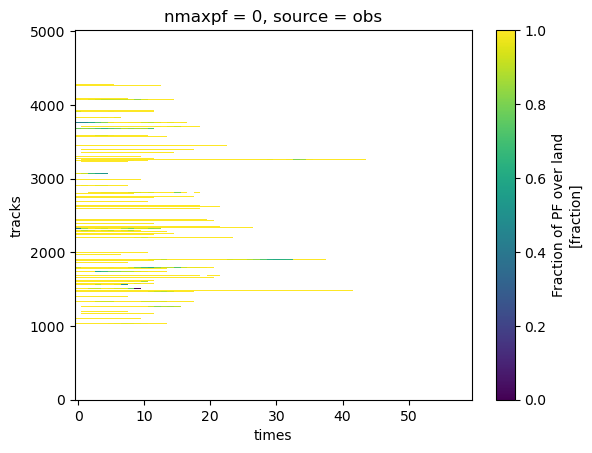

In [52]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

In [53]:
# TODO: use a simple method to separate possible merge/split tracks
# E.g., if max CCS area occur within the first 10% of a tracks start time: split; or within last 10% of a tracks end time: merge
# ds.ccs_area.max(dim='times')

In [54]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
        # df.columns = list(da['source'].data)
    return df

### CCS lifetime

In [55]:
da_tmp = (dss_pyflex_l.track_duration * time_resolution).transpose()
ccslifetime_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.track_duration * time_resolution).transpose()
ccslifetime_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [56]:
da_tmp = (dss_moaap_l.track_duration * time_resolution).transpose()
ccslifetime_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.track_duration * time_resolution).transpose()
ccslifetime_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [57]:
da_tmp = (dss_toocan_l.track_duration * time_resolution).transpose()
ccslifetime_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.track_duration * time_resolution).transpose()
ccslifetime_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [58]:
da_tmp = (dss_tobac_l.track_duration * time_resolution).transpose()
ccslifetime_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tobac_o.track_duration * time_resolution).transpose()
ccslifetime_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [59]:
da_tmp = (dss_tams_l.track_duration * time_resolution).transpose()
ccslifetime_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tams_o.track_duration * time_resolution).transpose()
ccslifetime_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [60]:
da_tmp = (dss_simtrack_l.track_duration * time_resolution).transpose()
ccslifetime_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_simtrack_o.track_duration * time_resolution).transpose()
ccslifetime_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [61]:
da_tmp = (dss_dl_l.track_duration * time_resolution).transpose()
ccslifetime_dl_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_dl_o.track_duration * time_resolution).transpose()
ccslifetime_dl_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [62]:
da_tmp = (dss_kfyao_l.track_duration * time_resolution).transpose()
ccslifetime_kfyao_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_kfyao_o.track_duration * time_resolution).transpose()
ccslifetime_kfyao_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [63]:
ccslifetime_pyflex_o

OBS  ARPEGE  IFS  MPAS  NICAM  SAM  UM  FV3  SCREAMv1
0     NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
1     NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
2     NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
3     NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
4     NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
...   ...     ...  ...   ...    ...  ...  ..  ...       ...
5011  NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       5.0
5012  NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       6.0
5013  NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
5014  NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       NaN
5015  NaN     NaN  NaN   NaN    NaN  NaN NaN  NaN       5.0

[5016 rows x 9 columns]

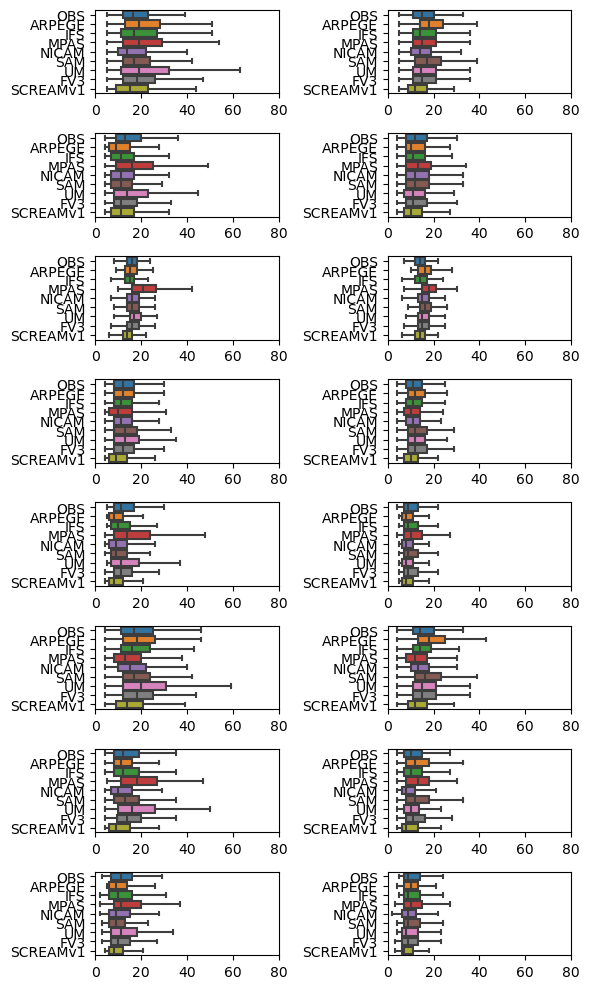

In [64]:
fig, axes = plt.subplots(8, 2, figsize=(6,10))
sns.boxplot(data=ccslifetime_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=ccslifetime_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=ccslifetime_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
sns.boxplot(data=ccslifetime_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
sns.boxplot(data=ccslifetime_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
sns.boxplot(data=ccslifetime_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)
sns.boxplot(data=ccslifetime_dl_o,  orient='h', ax=axes[6][0], showfliers=False)
sns.boxplot(data=ccslifetime_kfyao_o,  orient='h', ax=axes[7][0], showfliers=False)

sns.boxplot(data=ccslifetime_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=ccslifetime_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=ccslifetime_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
sns.boxplot(data=ccslifetime_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
sns.boxplot(data=ccslifetime_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
sns.boxplot(data=ccslifetime_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)
sns.boxplot(data=ccslifetime_dl_l,  orient='h', ax=axes[6][1], showfliers=False)
sns.boxplot(data=ccslifetime_kfyao_l,  orient='h', ax=axes[7][1], showfliers=False)

for row in range(8):
    for col in range(2):
        axes[row][col].set_xlim(0,80)
fig.tight_layout()

In [65]:
# fig, axes = plt.subplots(3, 2, figsize=(8,8))
# sns.boxplot(data=ccslifetime_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=ccslifetime_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=ccslifetime_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
# sns.boxplot(data=ccslifetime_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)

# sns.boxplot(data=ccslifetime_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=ccslifetime_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
# sns.boxplot(data=ccslifetime_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
# axes[0][0].set_xlim(0,80)
# axes[1][0].set_xlim(0,80)
# axes[2][0].set_xlim(0,80)
# axes[0][1].set_xlim(0,80)
# axes[1][1].set_xlim(0,80)
# axes[2][1].set_xlim(0,80)

### Max CCS area

In [66]:
da_tmp = (dss_pyflex_l.ccs_area.max(dim='times')).transpose()
maxccsarea_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.ccs_area.max(dim='times')).transpose()
maxccsarea_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [67]:
da_tmp = (dss_moaap_l.ccs_area.max(dim='times')).transpose()
maxccsarea_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.ccs_area.max(dim='times')).transpose()
maxccsarea_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [68]:
da_tmp = (dss_toocan_l.ccs_area.max(dim='times')).transpose()
maxccsarea_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.ccs_area.max(dim='times')).transpose()
maxccsarea_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [69]:
da_tmp = (dss_tobac_l.ccs_area.max(dim='times')).transpose()
maxccsarea_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tobac_o.ccs_area.max(dim='times')).transpose()
maxccsarea_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [70]:
da_tmp = (dss_tams_l.ccs_area.max(dim='times')).transpose()
maxccsarea_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tams_o.ccs_area.max(dim='times')).transpose()
maxccsarea_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [71]:
da_tmp = (dss_simtrack_l.ccs_area.max(dim='times')).transpose()
maxccsarea_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_simtrack_o.ccs_area.max(dim='times')).transpose()
maxccsarea_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [72]:
da_tmp = (dss_dl_l.ccs_area.max(dim='times')).transpose()
maxccsarea_dl_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_dl_o.ccs_area.max(dim='times')).transpose()
maxccsarea_dl_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [73]:
da_tmp = (dss_kfyao_l.ccs_area.max(dim='times')).transpose()
maxccsarea_kfyao_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_kfyao_o.ccs_area.max(dim='times')).transpose()
maxccsarea_kfyao_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [74]:
# Convert to log10, and replace -inf with NaN
log10maxccsarea_pyflex_o = np.log10(maxccsarea_pyflex_o)
log10maxccsarea_pyflex_l = np.log10(maxccsarea_pyflex_l)
log10maxccsarea_pyflex_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_pyflex_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_moaap_o = np.log10(maxccsarea_moaap_o)
log10maxccsarea_moaap_l = np.log10(maxccsarea_moaap_l)
log10maxccsarea_moaap_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_moaap_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_toocan_o = np.log10(maxccsarea_toocan_o)
log10maxccsarea_toocan_l = np.log10(maxccsarea_toocan_l)
log10maxccsarea_toocan_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_toocan_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_tobac_o = np.log10(maxccsarea_tobac_o)
log10maxccsarea_tobac_l = np.log10(maxccsarea_tobac_l)
log10maxccsarea_tobac_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_tobac_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_tams_o = np.log10(maxccsarea_tams_o)
log10maxccsarea_tams_l = np.log10(maxccsarea_tams_l)
log10maxccsarea_tams_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_tams_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_simtrack_o = np.log10(maxccsarea_simtrack_o)
log10maxccsarea_simtrack_l = np.log10(maxccsarea_simtrack_l)
log10maxccsarea_simtrack_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_simtrack_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_dl_o = np.log10(maxccsarea_dl_o)
log10maxccsarea_dl_l = np.log10(maxccsarea_dl_l)
log10maxccsarea_dl_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_dl_l.replace(-np.inf, np.nan, inplace=True)

log10maxccsarea_kfyao_o = np.log10(maxccsarea_kfyao_o)
log10maxccsarea_kfyao_l = np.log10(maxccsarea_kfyao_l)
log10maxccsarea_kfyao_o.replace(-np.inf, np.nan, inplace=True)
log10maxccsarea_kfyao_l.replace(-np.inf, np.nan, inplace=True)

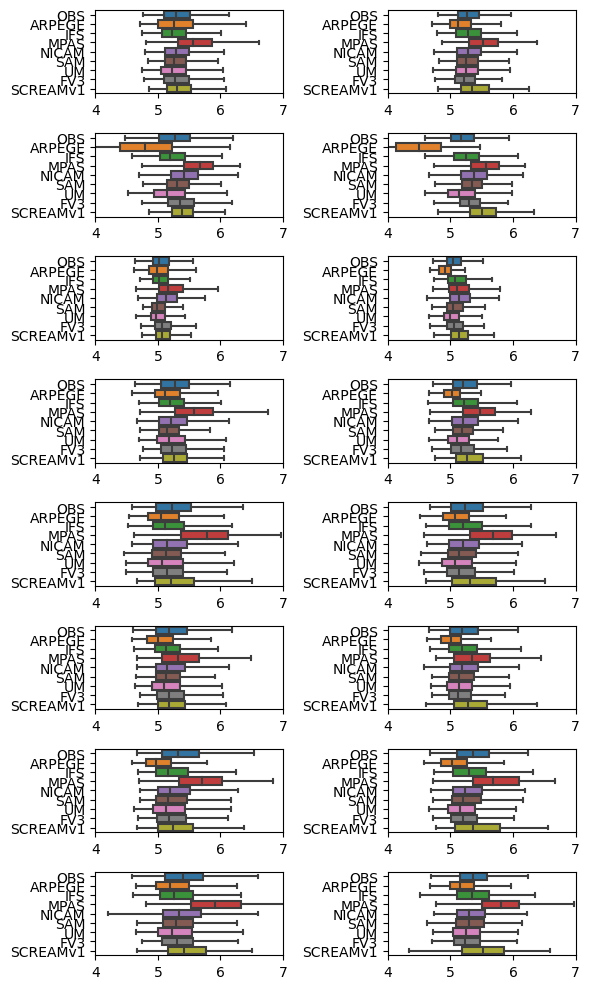

In [75]:
fig, axes = plt.subplots(8, 2, figsize=(6,10))
sns.boxplot(data=log10maxccsarea_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_dl_o,  orient='h', ax=axes[6][0], showfliers=False)
sns.boxplot(data=log10maxccsarea_kfyao_o,  orient='h', ax=axes[7][0], showfliers=False)

sns.boxplot(data=log10maxccsarea_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_dl_l,  orient='h', ax=axes[6][1], showfliers=False)
sns.boxplot(data=log10maxccsarea_kfyao_l,  orient='h', ax=axes[7][1], showfliers=False)

for row in range(8):
    for col in range(2):
        axes[row][col].set_xlim(4,7)
fig.tight_layout()

In [76]:
# fig, axes = plt.subplots(2, 2, figsize=(8,8))
# sns.boxplot(data=maxccsarea_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=maxccsarea_pyflex_l,  orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=maxccsarea_moaap_o,  orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=maxccsarea_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
# axes[0][0].set_xlim(4.5,6.8)
# axes[1][0].set_xlim(4.5,6.8)
# axes[0][1].set_xlim(4.5,6.8)
# axes[1][1].set_xlim(4.5,6.8)

### Lifetime-min min Tb

In [77]:
da_tmp = (dss_pyflex_l.corecold_mintb.min(dim='times')).transpose()
mintb_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.corecold_mintb.min(dim='times')).transpose()
mintb_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [78]:
da_tmp = (dss_moaap_l.corecold_mintb.min(dim='times')).transpose()
mintb_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.corecold_mintb.min(dim='times')).transpose()
mintb_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [79]:
da_tmp = (dss_toocan_l.corecold_mintb.min(dim='times')).transpose()
mintb_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.corecold_mintb.min(dim='times')).transpose()
mintb_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [80]:
da_tmp = (dss_tobac_l.corecold_mintb.min(dim='times')).transpose()
mintb_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tobac_o.corecold_mintb.min(dim='times')).transpose()
mintb_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [81]:
da_tmp = (dss_tams_l.corecold_mintb.min(dim='times')).transpose()
mintb_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tams_o.corecold_mintb.min(dim='times')).transpose()
mintb_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [82]:
da_tmp = (dss_simtrack_l.corecold_mintb.min(dim='times')).transpose()
mintb_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_simtrack_o.corecold_mintb.min(dim='times')).transpose()
mintb_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [83]:
da_tmp = (dss_dl_l.corecold_mintb.min(dim='times')).transpose()
mintb_dl_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_dl_o.corecold_mintb.min(dim='times')).transpose()
mintb_dl_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [84]:
da_tmp = (dss_kfyao_l.corecold_mintb.min(dim='times')).transpose()
mintb_kfyao_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_kfyao_o.corecold_mintb.min(dim='times')).transpose()
mintb_kfyao_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

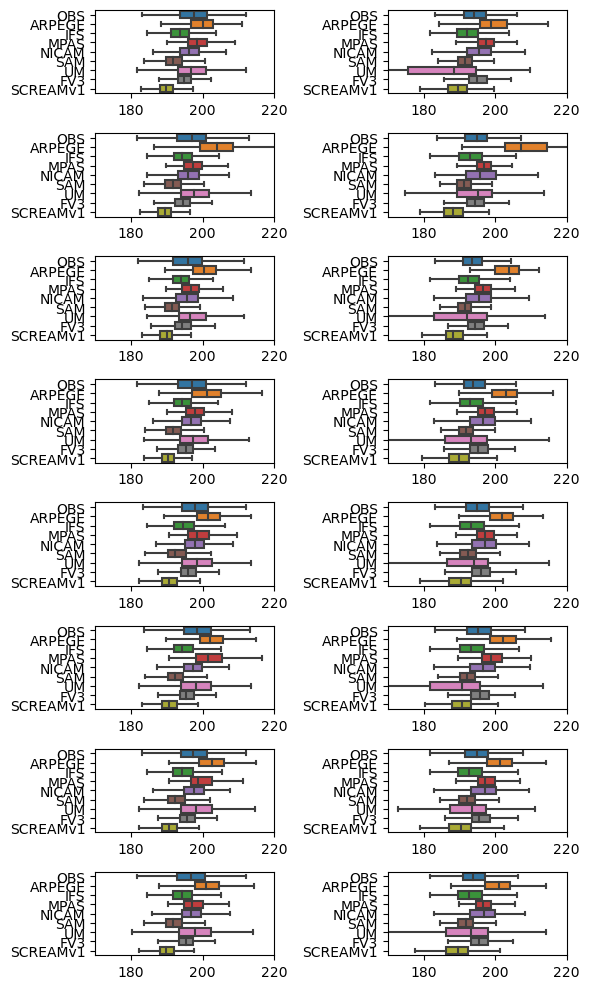

In [85]:
fig, axes = plt.subplots(8, 2, figsize=(6,10))
sns.boxplot(data=mintb_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=mintb_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=mintb_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
sns.boxplot(data=mintb_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
sns.boxplot(data=mintb_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
sns.boxplot(data=mintb_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)
sns.boxplot(data=mintb_dl_o,  orient='h', ax=axes[6][0], showfliers=False)
sns.boxplot(data=mintb_kfyao_o,  orient='h', ax=axes[7][0], showfliers=False)

sns.boxplot(data=mintb_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=mintb_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=mintb_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
sns.boxplot(data=mintb_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
sns.boxplot(data=mintb_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
sns.boxplot(data=mintb_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)
sns.boxplot(data=mintb_dl_l,  orient='h', ax=axes[6][1], showfliers=False)
sns.boxplot(data=mintb_kfyao_l,  orient='h', ax=axes[7][1], showfliers=False)

for row in range(8):
    for col in range(2):
        axes[row][col].set_xlim(170,220)
fig.tight_layout()

### Lifetime-average min Tb

In [86]:
# da_tmp = (dss_pyflex_l.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# da_tmp = (dss_pyflex_o.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [87]:
# da_tmp = (dss_moaap_l.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# da_tmp = (dss_moaap_o.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [88]:
# da_tmp = (dss_toocan_l.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# da_tmp = (dss_toocan_o.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [89]:
# da_tmp = (dss_tobac_l.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# da_tmp = (dss_tobac_o.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [90]:
# da_tmp = (dss_tams_l.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# da_tmp = (dss_tams_o.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [91]:
# da_tmp = (dss_simtrack_l.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

# da_tmp = (dss_simtrack_o.corecold_mintb.mean(dim='times')).transpose()
# avgmintb_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [92]:
# fig, axes = plt.subplots(6, 2, figsize=(8,8))
# sns.boxplot(data=avgmintb_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
# sns.boxplot(data=avgmintb_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
# sns.boxplot(data=avgmintb_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
# sns.boxplot(data=avgmintb_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
# sns.boxplot(data=avgmintb_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
# sns.boxplot(data=avgmintb_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)

# sns.boxplot(data=avgmintb_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
# sns.boxplot(data=avgmintb_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
# sns.boxplot(data=avgmintb_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
# sns.boxplot(data=avgmintb_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
# sns.boxplot(data=avgmintb_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
# sns.boxplot(data=avgmintb_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)

# for row in range(6):
#     for col in range(2):
#         axes[row][col].set_xlim(180,230)
# fig.tight_layout()

### Total volume rain

In [93]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

da_tmp = (dss_pyflex_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [94]:
da_tmp = (dss_moaap_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [95]:
da_tmp = (dss_toocan_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [96]:
da_tmp = (dss_tobac_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tobac_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [97]:
da_tmp = (dss_tams_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tams_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [98]:
da_tmp = (dss_simtrack_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_simtrack_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [99]:
da_tmp = (dss_dl_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_dl_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_dl_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_dl_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [100]:
da_tmp = (dss_kfyao_l.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_kfyao_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_kfyao_o.total_rain.sum(dim='times') * pixel_radius**2).transpose()
pfvolrain_kfyao_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [101]:
# Convert to log10, and replace -inf with NaN
log10pfvolrain_pyflex_o = np.log10(pfvolrain_pyflex_o)
log10pfvolrain_pyflex_l = np.log10(pfvolrain_pyflex_l)
log10pfvolrain_pyflex_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_pyflex_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_moaap_o = np.log10(pfvolrain_moaap_o)
log10pfvolrain_moaap_l = np.log10(pfvolrain_moaap_l)
log10pfvolrain_moaap_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_moaap_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_toocan_o = np.log10(pfvolrain_toocan_o)
log10pfvolrain_toocan_l = np.log10(pfvolrain_toocan_l)
log10pfvolrain_toocan_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_toocan_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_tobac_o = np.log10(pfvolrain_tobac_o)
log10pfvolrain_tobac_l = np.log10(pfvolrain_tobac_l)
log10pfvolrain_tobac_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_tobac_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_tams_o = np.log10(pfvolrain_tams_o)
log10pfvolrain_tams_l = np.log10(pfvolrain_tams_l)
log10pfvolrain_tams_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_tams_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_simtrack_o = np.log10(pfvolrain_simtrack_o)
log10pfvolrain_simtrack_l = np.log10(pfvolrain_simtrack_l)
log10pfvolrain_simtrack_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_simtrack_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_dl_o = np.log10(pfvolrain_dl_o)
log10pfvolrain_dl_l = np.log10(pfvolrain_dl_l)
log10pfvolrain_dl_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_dl_l.replace(-np.inf, np.nan, inplace=True)

log10pfvolrain_kfyao_o = np.log10(pfvolrain_kfyao_o)
log10pfvolrain_kfyao_l = np.log10(pfvolrain_kfyao_l)
log10pfvolrain_kfyao_o.replace(-np.inf, np.nan, inplace=True)
log10pfvolrain_kfyao_l.replace(-np.inf, np.nan, inplace=True)

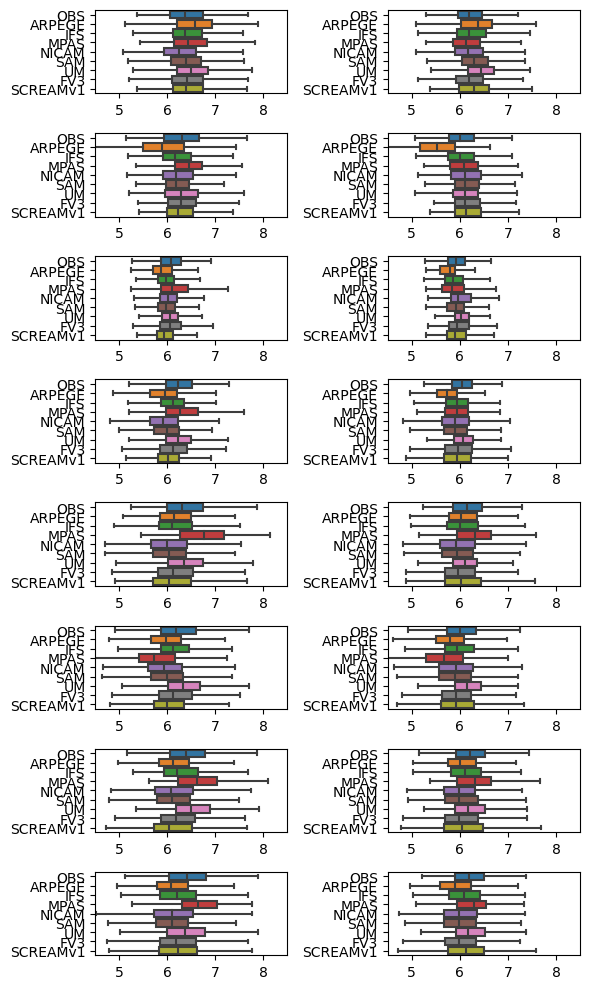

In [102]:
fig, axes = plt.subplots(8, 2, figsize=(6,10))
sns.boxplot(data=log10pfvolrain_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_dl_o,  orient='h', ax=axes[6][0], showfliers=False)
sns.boxplot(data=log10pfvolrain_kfyao_o,  orient='h', ax=axes[7][0], showfliers=False)

sns.boxplot(data=log10pfvolrain_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_dl_l,  orient='h', ax=axes[6][1], showfliers=False)
sns.boxplot(data=log10pfvolrain_kfyao_l,  orient='h', ax=axes[7][1], showfliers=False)

for row in range(8):
    for col in range(2):
        axes[row][col].set_xlim(4.5,8.5)
fig.tight_layout()

### Heavy rain volume

In [103]:
da_tmp = (dss_pyflex_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [104]:
da_tmp = (dss_moaap_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [105]:
da_tmp = (dss_toocan_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [106]:
da_tmp = (dss_tobac_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tobac_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [107]:
da_tmp = (dss_tams_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tams_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [108]:
da_tmp = (dss_simtrack_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_simtrack_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [109]:
da_tmp = (dss_dl_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_dl_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_dl_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_dl_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [110]:
da_tmp = (dss_kfyao_l.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_kfyao_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_kfyao_o.total_heavyrain.sum(dim='times') * pixel_radius**2).transpose()
pfheavyvolrain_kfyao_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

### Heavy rain volume ratio

In [111]:
pfhrr_pyflex_l = 100 * pfheavyvolrain_pyflex_l / pfvolrain_pyflex_l
pfhrr_pyflex_o = 100 * pfheavyvolrain_pyflex_o / pfvolrain_pyflex_o

pfhrr_moaap_l = 100 * pfheavyvolrain_moaap_l / pfvolrain_moaap_l
pfhrr_moaap_o = 100 * pfheavyvolrain_moaap_o / pfvolrain_moaap_o

pfhrr_toocan_l = 100 * pfheavyvolrain_toocan_l / pfvolrain_toocan_l
pfhrr_toocan_o = 100 * pfheavyvolrain_toocan_o / pfvolrain_toocan_o

pfhrr_tobac_l = 100 * pfheavyvolrain_tobac_l / pfvolrain_tobac_l
pfhrr_tobac_o = 100 * pfheavyvolrain_tobac_o / pfvolrain_tobac_o

pfhrr_tams_l = 100 * pfheavyvolrain_tams_l / pfvolrain_tams_l
pfhrr_tams_o = 100 * pfheavyvolrain_tams_o / pfvolrain_tams_o

pfhrr_simtrack_l = 100 * pfheavyvolrain_simtrack_l / pfvolrain_simtrack_l
pfhrr_simtrack_o = 100 * pfheavyvolrain_simtrack_o / pfvolrain_simtrack_o

pfhrr_dl_l = 100 * pfheavyvolrain_dl_l / pfvolrain_dl_l
pfhrr_dl_o = 100 * pfheavyvolrain_dl_o / pfvolrain_dl_o

pfhrr_kfyao_l = 100 * pfheavyvolrain_kfyao_l / pfvolrain_kfyao_l
pfhrr_kfyao_o = 100 * pfheavyvolrain_kfyao_o / pfvolrain_kfyao_o

In [112]:
# Convert to log10, and replace -inf with NaN
log10pfhrr_pyflex_o = np.log10(pfhrr_pyflex_o)
log10pfhrr_pyflex_l = np.log10(pfhrr_pyflex_l)
pfhrr_pyflex_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_pyflex_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_moaap_o = np.log10(pfhrr_moaap_o)
log10pfhrr_moaap_l = np.log10(pfhrr_moaap_l)
pfhrr_moaap_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_moaap_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_toocan_o = np.log10(pfhrr_toocan_o)
log10pfhrr_toocan_l = np.log10(pfhrr_toocan_l)
pfhrr_toocan_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_toocan_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_tobac_o = np.log10(pfhrr_tobac_o)
log10pfhrr_tobac_l = np.log10(pfhrr_tobac_l)
pfhrr_tobac_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_tobac_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_tams_o = np.log10(pfhrr_tams_o)
log10pfhrr_tams_l = np.log10(pfhrr_tams_l)
pfhrr_tams_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_tams_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_simtrack_o = np.log10(pfhrr_simtrack_o)
log10pfhrr_simtrack_l = np.log10(pfhrr_simtrack_l)
pfhrr_simtrack_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_simtrack_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_dl_o = np.log10(pfhrr_dl_o)
log10pfhrr_dl_l = np.log10(pfhrr_dl_l)
pfhrr_dl_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_dl_o.replace(-np.inf, np.nan, inplace=True)

log10pfhrr_kfyao_o = np.log10(pfhrr_kfyao_o)
log10pfhrr_kfyao_l = np.log10(pfhrr_kfyao_l)
pfhrr_kfyao_l.replace(-np.inf, np.nan, inplace=True)
pfhrr_kfyao_o.replace(-np.inf, np.nan, inplace=True)

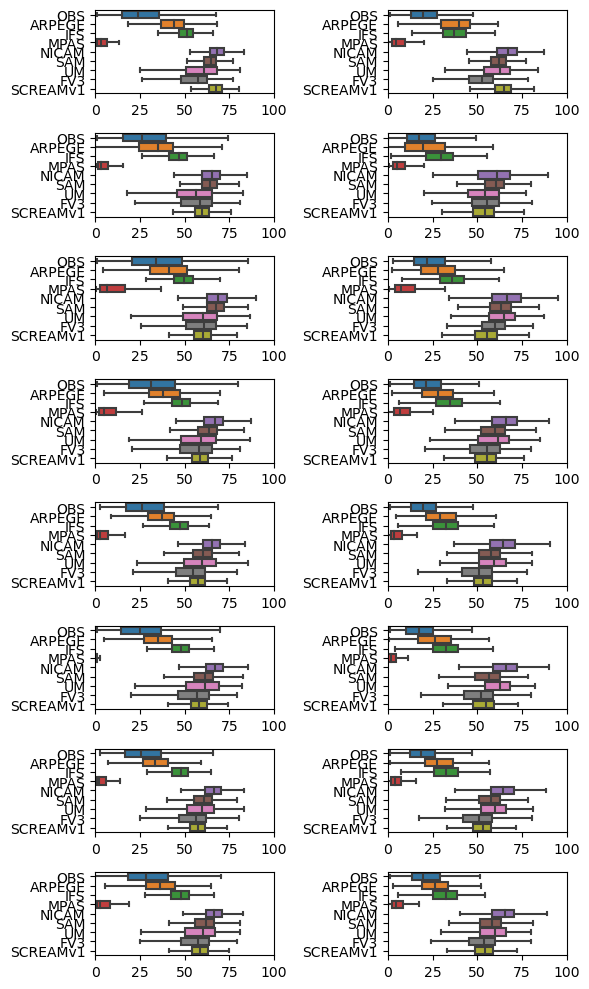

In [113]:
fig, axes = plt.subplots(8, 2, figsize=(6,10))
sns.boxplot(data=pfhrr_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=pfhrr_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=pfhrr_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
sns.boxplot(data=pfhrr_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
sns.boxplot(data=pfhrr_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
sns.boxplot(data=pfhrr_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)
sns.boxplot(data=pfhrr_dl_o,  orient='h', ax=axes[6][0], showfliers=False)
sns.boxplot(data=pfhrr_kfyao_o,  orient='h', ax=axes[7][0], showfliers=False)

sns.boxplot(data=pfhrr_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=pfhrr_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=pfhrr_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
sns.boxplot(data=pfhrr_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
sns.boxplot(data=pfhrr_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
sns.boxplot(data=pfhrr_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)
sns.boxplot(data=pfhrr_dl_l,  orient='h', ax=axes[6][1], showfliers=False)
sns.boxplot(data=pfhrr_kfyao_l,  orient='h', ax=axes[7][1], showfliers=False)

for row in range(8):
    for col in range(2):
        axes[row][col].set_xlim(0,100)
fig.tight_layout()

### Mean PF rain rate

In [114]:
da_tmp = (dss_pyflex_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_pyflex_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_pyflex_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_pyflex_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [115]:
da_tmp = (dss_moaap_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_moaap_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_moaap_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_moaap_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [116]:
da_tmp = (dss_toocan_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_toocan_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_toocan_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_toocan_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [117]:
da_tmp = (dss_tobac_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_tobac_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tobac_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_tobac_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [118]:
da_tmp = (dss_tams_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_tams_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_tams_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_tams_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [119]:
da_tmp = (dss_simtrack_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_simtrack_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_simtrack_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_simtrack_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [120]:
da_tmp = (dss_dl_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_dl_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_dl_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_dl_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

In [121]:
da_tmp = (dss_kfyao_l.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_kfyao_l = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

da_tmp = (dss_kfyao_o.pf_rainrate.mean(dim='times')).transpose()
meanpfrainrate_kfyao_o = dataarray_to_dataframe(da_tmp, column_names=name_map.values())

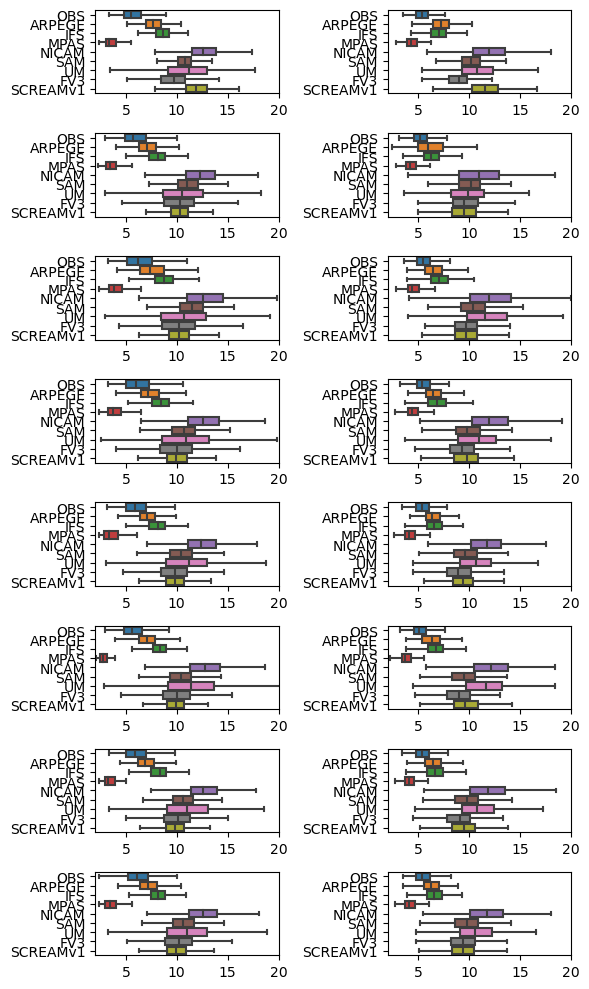

In [122]:
fig, axes = plt.subplots(8, 2, figsize=(6,10))
sns.boxplot(data=meanpfrainrate_pyflex_o,  orient='h', ax=axes[0][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_moaap_o,  orient='h', ax=axes[1][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_toocan_o,  orient='h', ax=axes[2][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_tobac_o,  orient='h', ax=axes[3][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_tams_o,  orient='h', ax=axes[4][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_simtrack_o,  orient='h', ax=axes[5][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_dl_o,  orient='h', ax=axes[6][0], showfliers=False)
sns.boxplot(data=meanpfrainrate_kfyao_o,  orient='h', ax=axes[7][0], showfliers=False)

sns.boxplot(data=meanpfrainrate_pyflex_l,  orient='h', ax=axes[0][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_moaap_l,  orient='h', ax=axes[1][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_toocan_l,  orient='h', ax=axes[2][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_tobac_l,  orient='h', ax=axes[3][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_tams_l,  orient='h', ax=axes[4][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_simtrack_l,  orient='h', ax=axes[5][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_dl_l,  orient='h', ax=axes[6][1], showfliers=False)
sns.boxplot(data=meanpfrainrate_kfyao_l,  orient='h', ax=axes[7][1], showfliers=False)

for row in range(8):
    for col in range(2):
        axes[row][col].set_xlim(2,20)
fig.tight_layout()

In [123]:
ccslifetime_pyflex_o.median(), ccslifetime_moaap_o.median()

(OBS         16.5
 ARPEGE      19.0
 IFS         17.0
 MPAS        19.0
 NICAM       14.0
 SAM         17.0
 UM          19.0
 FV3         18.0
 SCREAMv1    15.0
 dtype: float64,
 OBS         13.0
 ARPEGE       9.0
 IFS         11.0
 MPAS        16.0
 NICAM       11.0
 SAM         11.0
 UM          14.0
 FV3         11.0
 SCREAMv1    11.0
 dtype: float64)

In [124]:
def get_diffs_percent(arrays):
    """
    Calculate relative difference between models & obs
    """
    nrow = len(arrays)
    ncol = len(arrays[0])-1
    # Make output array
    arr_out = np.full((nrow,ncol), np.NaN, dtype=float)
    for row in range(nrow):
        arr = arrays[row]
        arr_out[row,:] = 100 * (arr[1:] - arr['OBS']) / arr['OBS']
    return arr_out

In [125]:
list(name_map.values())[1:]

['ARPEGE', 'IFS', 'MPAS', 'NICAM', 'SAM', 'UM', 'FV3', 'SCREAMv1']

In [126]:
ylabels = ['O (PyFLEXTRKR)','O (MOAAP)','O (TOOCAN)','O (tobac)','O (TAMS)','O (simpleTrack)','O (DL)','O (KFyAO)',
           'L (PyFLEXTRKR)','L (MOAAP)','L (TOOCAN)','L (tobac)','L (TAMS)','L (simpleTrack)','L (DL)','L (KFyAO)',]
xlabels = list(name_map.values())[1:]

arrays = [ccslifetime_pyflex_o.median(), ccslifetime_moaap_o.median(), ccslifetime_toocan_o.median(), ccslifetime_tobac_o.median(), 
          ccslifetime_tams_o.median(), ccslifetime_simtrack_o.median(), ccslifetime_dl_o.median(), ccslifetime_kfyao_o.median(),
          ccslifetime_pyflex_l.median(), ccslifetime_moaap_l.median(), ccslifetime_toocan_l.median(), ccslifetime_tobac_l.median(), 
          ccslifetime_tams_l.median(), ccslifetime_simtrack_l.median(), ccslifetime_dl_l.median(), ccslifetime_kfyao_l.median(),]
ccslifetime_diffpercent_med_all = get_diffs_percent(arrays)

In [127]:
arrays = [maxccsarea_pyflex_o.median(), maxccsarea_moaap_o.median(), maxccsarea_toocan_o.median(), maxccsarea_tobac_o.median(), 
          maxccsarea_tams_o.median(), maxccsarea_simtrack_o.median(), maxccsarea_dl_o.median(), maxccsarea_kfyao_o.median(),
          maxccsarea_pyflex_l.median(), maxccsarea_moaap_l.median(), maxccsarea_toocan_l.median(), maxccsarea_tobac_l.median(), 
          maxccsarea_tams_l.median(), maxccsarea_simtrack_l.median(), maxccsarea_dl_l.median(), maxccsarea_kfyao_l.median(),]
maxccsarea_diffpercent_med_all = get_diffs_percent(arrays)

In [128]:
# arrays = [avgmintb_pyflex_o.median(), avgmintb_moaap_o.median(), avgmintb_toocan_o.median(), avgmintb_tobac_o.median(), avgmintb_tams_o.median(), avgmintb_simtrack_o.median(),
#           avgmintb_pyflex_l.median(), avgmintb_moaap_l.median(), avgmintb_toocan_l.median(), avgmintb_tobac_l.median(), avgmintb_tams_l.median(), avgmintb_simtrack_l.median(),]
# avgmintb_diffpercent_med_all = get_diffs_percent(arrays)

In [129]:
arrays = [mintb_pyflex_o.median(), mintb_moaap_o.median(), mintb_toocan_o.median(), mintb_tobac_o.median(), 
          mintb_tams_o.median(), mintb_simtrack_o.median(), mintb_dl_o.median(), mintb_kfyao_o.median(),
          mintb_pyflex_l.median(), mintb_moaap_l.median(), mintb_toocan_l.median(), mintb_tobac_l.median(), 
          mintb_tams_l.median(), mintb_simtrack_l.median(), mintb_dl_l.median(), mintb_kfyao_l.median(),]
mintb_diffpercent_med_all = get_diffs_percent(arrays)

In [130]:
arrays = [pfvolrain_pyflex_o[pfvolrain_pyflex_o > 0].median(), pfvolrain_moaap_o[pfvolrain_moaap_o > 0].median(), pfvolrain_toocan_o[pfvolrain_toocan_o > 0].median(),
          pfvolrain_tobac_o[pfvolrain_tobac_o > 0].median(), pfvolrain_tams_o[pfvolrain_tams_o > 0].median(), pfvolrain_simtrack_o[pfvolrain_simtrack_o > 0].median(),
          pfvolrain_dl_o[pfvolrain_dl_o > 0].median(), pfvolrain_kfyao_o[pfvolrain_kfyao_o > 0].median(),
          pfvolrain_pyflex_l[pfvolrain_pyflex_l > 0].median(), pfvolrain_moaap_l[pfvolrain_moaap_l > 0].median(), pfvolrain_toocan_l[pfvolrain_toocan_l > 0].median(),
          pfvolrain_tobac_l[pfvolrain_tobac_l > 0].median(), pfvolrain_tams_l[pfvolrain_tams_l > 0].median(), pfvolrain_simtrack_l[pfvolrain_simtrack_l > 0].median(),
          pfvolrain_dl_l[pfvolrain_dl_l > 0].median(), pfvolrain_kfyao_l[pfvolrain_kfyao_l > 0].median(),]
pfvolrain_diffpercent_med_all = get_diffs_percent(arrays)

In [131]:
arrays = [meanpfrainrate_pyflex_o.median(), meanpfrainrate_moaap_o.median(), meanpfrainrate_toocan_o.median(), meanpfrainrate_tobac_o.median(), 
          meanpfrainrate_tams_o.median(), meanpfrainrate_simtrack_o.median(), meanpfrainrate_dl_o.median(), meanpfrainrate_kfyao_o.median(),
          meanpfrainrate_pyflex_l.median(), meanpfrainrate_moaap_l.median(), meanpfrainrate_toocan_l.median(), meanpfrainrate_tobac_o.median(), 
          meanpfrainrate_tams_l.median(), meanpfrainrate_simtrack_l.median(), meanpfrainrate_dl_l.median(), meanpfrainrate_kfyao_l.median(),]
meanpfrainrate_diffpercent_med_all = get_diffs_percent(arrays)

In [132]:
arrays = [pfhrr_pyflex_o.median(), pfhrr_moaap_o.median(), pfhrr_toocan_o.median(), pfhrr_tobac_o.median(), 
          pfhrr_tams_o.median(), pfhrr_simtrack_o.median(), pfhrr_dl_o.median(), pfhrr_kfyao_o.median(),
          pfhrr_pyflex_l.median(), pfhrr_moaap_l.median(), pfhrr_toocan_l.median(), pfhrr_tobac_l.median(), 
          pfhrr_tams_l.median(), pfhrr_simtrack_l.median(), pfhrr_dl_l.median(), pfhrr_kfyao_l.median(),]
pfhrr_diffpercent_med_all = get_diffs_percent(arrays)

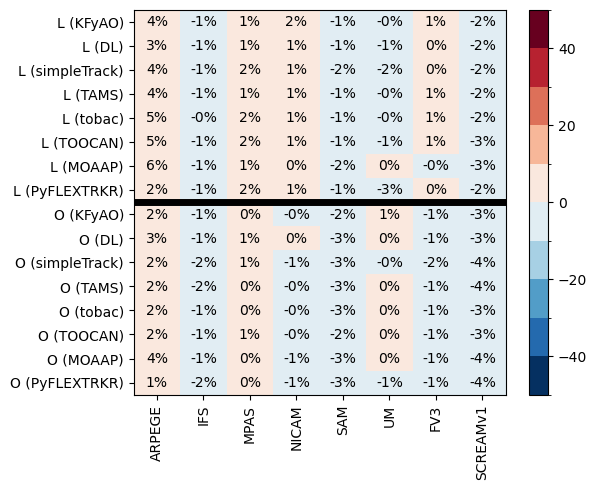

In [133]:
fig, ax = plt.subplots(1,1,figsize=[6,5], dpi=100)
levels = np.arange(-50, 51, 10)
cmap = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
# pcm = ax.pcolormesh(ccslifetime_diffpercent_med_all, norm=norm, cmap=cmap)
# pcm = ax.pcolormesh(maxccsarea_diffpercent_med_all, norm=norm, cmap=cmap)
pcm = ax.pcolormesh(mintb_diffpercent_med_all, norm=norm, cmap=cmap)

fig.colorbar(pcm)

# Axis labels
n_xlabels = len(xlabels)
n_ylabels = len(ylabels)
x_centers = np.arange(0.5, n_xlabels+0.5, 1)
y_centers = np.arange(0.5, n_ylabels+0.5, 1)
ax.set_xticks(x_centers, xlabels, rotation=90)
ax.set_yticks(y_centers, ylabels)

# Shade the background with colors
# Get x-axis limits
ymin, ymax = ax.get_ylim()
midpoint = (ymin + ymax) / 2
ax.axhline(y=midpoint, lw=5, color='k')

# Add text annotations at the center of each cell
for i, x in enumerate(x_centers):
    for j, y in enumerate(y_centers):
        # ax.annotate(f'{ccslifetime_diffpercent_med_all[j, i]:.0f}%', (x, y), color='k', fontsize=8, ha='center', va='center')
        # ax.annotate(f'{maxccsarea_diffpercent_med_all[j, i]:.0f}%', (x, y), color='k', fontsize=10, ha='center', va='center')
        ax.annotate(f'{mintb_diffpercent_med_all[j, i]:.0f}%', (x, y), color='k', fontsize=10, ha='center', va='center')
        

## Function to plot mean difference on (m x n) panels

In [134]:
def shade_bias_mxn(nrow, ncol, data_arr, titles=None, xlabels=None, ylabels=None, show_xlabel=None, show_ylabel=None, xrotation=90,
                   levels=None, cmap=None, cblabels=None, cbticks=None, cbshrink=1, label_topbot=None, label_colors=None, subtitle=None,
                   figsize=[10,10], fontsize=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    
    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = axes[row][col]
            data = data_arr[row][col]
            
            # Normalize color
            cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
            norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
            pcm = ax.pcolormesh(data, norm=norm, cmap=cmap)
            ax.set_title(titles[row][col], loc='left')

            # Axis labels
            n_xlabels = len(xlabels)
            n_ylabels = len(ylabels)
            x_centers = np.arange(0.5, n_xlabels+0.5, 1)
            y_centers = np.arange(0.5, n_ylabels+0.5, 1)
            if show_xlabel[row][col]:
                ax.set_xticks(x_centers, xlabels, rotation=xrotation, ha='right')
            else:
                ax.set_xticks(x_centers, ['']*n_xlabels, rotation=xrotation, ha='right')
                # ax.set_x
            if show_ylabel[row][col]:
                ax.set_yticks(y_centers, ylabels)
            else:
                ax.set_yticks(y_centers, ['']*n_ylabels)
                
            # Label yaxis
            if (col == 0):
                ax.text(-0.45, 0.25, label_topbot[0], color=label_colors[0], va='center', ha='center', rotation=90, weight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)
                ax.text(-0.45, 0.75, label_topbot[1], color=label_colors[1], va='center', ha='center', rotation=90, weight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)

            # Get x-axis limits
            ymin, ymax = ax.get_ylim()
            midpoint = (ymin + ymax) / 2
            ax.axhline(y=midpoint, lw=5, color='k')

            # Add text annotations at the center of each cell
            for i, x in enumerate(x_centers):
                for j, y in enumerate(y_centers):
                    ax.annotate(f'{data[j, i]:.0f}%', (x, y), color='k', fontsize=fontsize*0.7, ha='center', va='center')
                    
    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    # Plot figure title
    fig.suptitle(subtitle, y=1.05, fontsize=fontsize*3, fontweight='bold')
    # Colorbar
    fig.colorbar(pcm, ax=axes[:,:], label=cblabels, ticks=cbticks, extend='both', pad=0.01, shrink=cbshrink)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

    return fig

In [135]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(b)', '(c)', '(d)', '(e)' ,'(f)']
elif PHASE == 'Winter':
    panel_numbers = ['(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
print(panel_numbers)

['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']


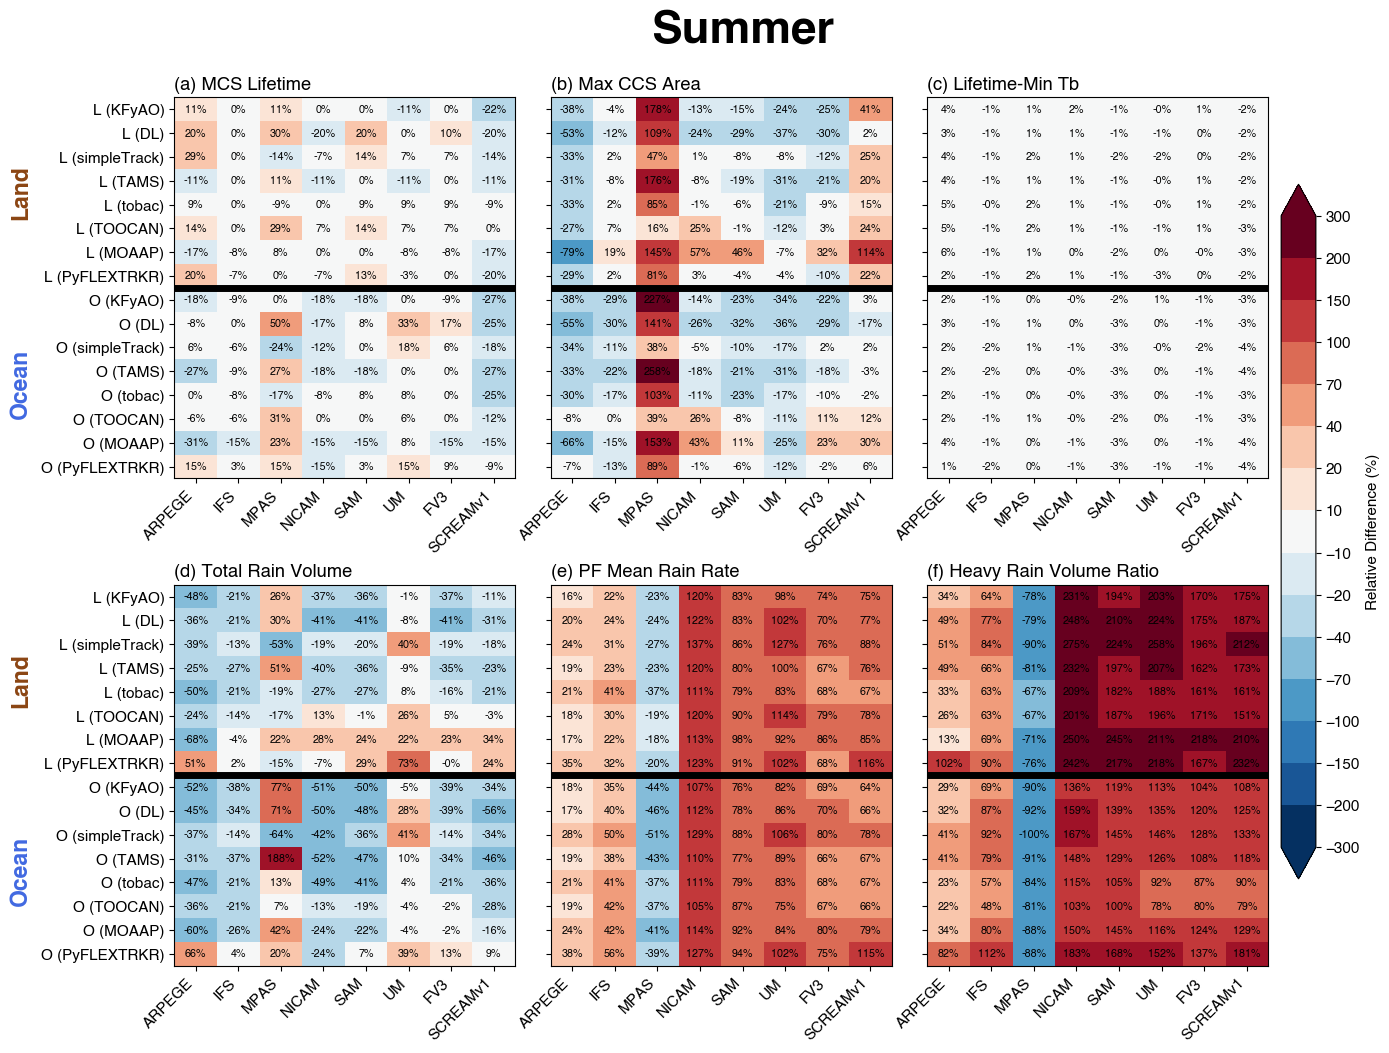

In [136]:
subtitle = f'{PHASE}'
data_arr = [
    [ccslifetime_diffpercent_med_all, maxccsarea_diffpercent_med_all, mintb_diffpercent_med_all],
    [pfvolrain_diffpercent_med_all, meanpfrainrate_diffpercent_med_all, pfhrr_diffpercent_med_all]
]
titles = [
    [f'{panel_numbers[0]} MCS Lifetime', f'{panel_numbers[1]} Max CCS Area', f'{panel_numbers[2]} Lifetime-Min Tb'],
    [f'{panel_numbers[3]} Total Rain Volume', f'{panel_numbers[4]} PF Mean Rain Rate', f'{panel_numbers[5]} Heavy Rain Volume Ratio'],
]
show_xlabel = [[True,True,True,],[True,True,True,]]
show_ylabel = [[True,False,False,],[True,False,False,]]
# levels = np.arange(-100, 101, 20)
levels = [-300,-200,-150,-100,-70,-40,-20,-10,10,20,40,70,100,150,200,300]
# levels = np.delete(levels, int((len(levels)-1)/2))
cbticks = levels
cblabels = 'Relative Difference (%)'
cmap = 'RdBu_r'
cbshrink = 0.8
label_topbot = ['Ocean', 'Land']
label_colors = ['royalblue', 'saddlebrown']
xrotation = 45
figsize = [15,10]
fontsize = 11
figname = f'{figdir}RelativeDiff_mcs_properties_2x3_median_all.png'
fig = shade_bias_mxn(2, 3, data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, show_xlabel=show_xlabel, show_ylabel=show_ylabel, subtitle=subtitle, xrotation=xrotation,
                     levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, cbshrink=cbshrink, label_topbot=label_topbot, label_colors=label_colors,
                     figsize=figsize, fontsize=fontsize)

In [137]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/RelativeDiff_mcs_properties_2x3_median_all.png'

## Function to plot mirror box plot on (m x n) panels

In [138]:
def boxplot_mirror_mxn(nrow, ncol, data_top, data_bot, titles, xlabels, legends, figname,  
                        map_show=False, map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0], map_bottop='top', panel_colors=None,
                        legend_fontsize=11, legend_loc='best', label_topbot=None, legend_ncol=None, figsize=[10,10], fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1], width_ratios=[1])
    gs.update(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)
    # Use GridSpecFromSubplotSpec to setup top and bottom mirror panels
    gs_top = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.35, hspace=0)
    gs_bot = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1], height_ratios=[0.5,0.5], width_ratios=[1,1,1,1], wspace=0.35, hspace=0)

    lcolors = {
        'obs': 'gray', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    
    meanprops = {"marker": "o", "markerfacecolor": "r", "markeredgecolor": "k"}
    medianprops = {'linewidth': 3}
    barwidth = 0.5
    # pcolors = list(lcolors.values())[:data_top[0][0].shape[1]]
    pcolors = [lcolors[key] for key in name_map.keys()]
    notch = False

    # Top row
    row = 0
    for col in range(0, ncol):
        # Top panel
        ax1 = plt.subplot(gs_top[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_top[1,col], sharex=ax1)
        ax2.invert_yaxis()
        # ax1.xaxis.set_ticklabels([])
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(-0.35, 0.5, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(-0.35, 0.5, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            # ax1.legend(fontsize=legend_fontsize, loc=legend_loc, ncols=legend_ncol)


        # Plot inset map
        if (map_show):
            if (row == map_panel[0]) & (col == map_panel[1]):
                if map_bottop == 'top':
                    ax_map = ax1
                if map_bottop == 'bot':
                    ax_map = ax2
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax_map, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)
                
    # Bottom row
    row = 1
    for col in range(0, ncol): 
        # Top panel
        ax1 = plt.subplot(gs_bot[0,col])
        sns.boxplot(data=data_top[row][col], orient='h', ax=ax1, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Bottom mirror panel
        ax2 = plt.subplot(gs_bot[1,col], sharex=ax1)
        ax2.invert_yaxis()
        sns.boxplot(data=data_bot[row][col], orient='h', ax=ax2, palette=pcolors, showfliers=False, showmeans=True, width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
        # Labels, gridlines, etc.
        ax1.grid(axis='x', ls='--')
        ax2.grid(axis='x', ls='--')
        ax1.set_title(titles[row][col], loc='left')
        ax2.set_xlabel(xlabels[row][col])
        ax1.tick_params(labelbottom=False)
        if panel_colors is not None:
            ax1.set_facecolor(panel_colors['top'])
            ax2.set_facecolor(panel_colors['bot'])
        # Label yaxis, legend
        if (col == 0):
            ax1.text(-0.35, 0.5, label_topbot[0], va='center', ha='center', rotation=90, weight='bold', transform=ax1.transAxes)
            ax2.text(-0.35, 0.5, label_topbot[1], va='center', ha='center', rotation=90, weight='bold', transform=ax2.transAxes)
            
        fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

### Set up legends, inset map

In [139]:
# Inset map settings
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'25%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-180, 179, -35, 50], [-180, 179], [-15, 30])

## PyFLEXTRKR vs. KFyAO

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

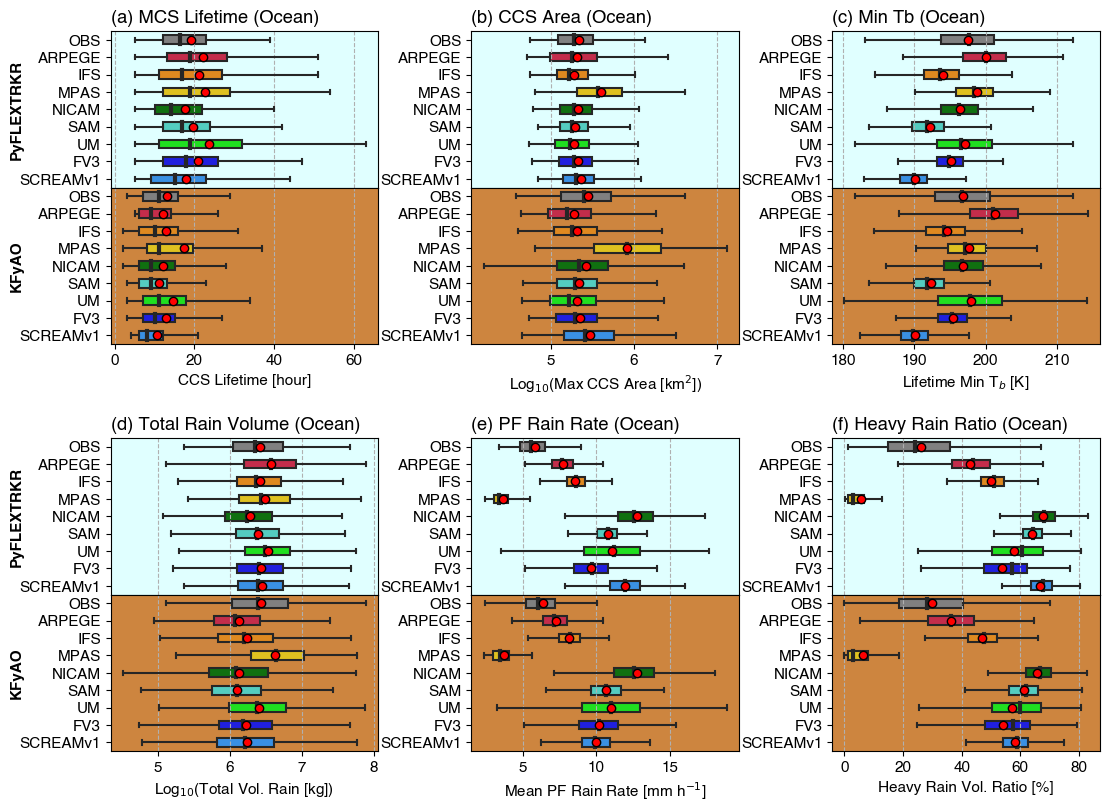

In [140]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_kfyao_o, log10maxccsarea_kfyao_o, mintb_kfyao_o, ],
    [log10pfvolrain_kfyao_o, meanpfrainrate_kfyao_o, pfhrr_kfyao_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'KFyAO']
panel_colors = {'top':'lightcyan', 'bot':'peru'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_KFyAO.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

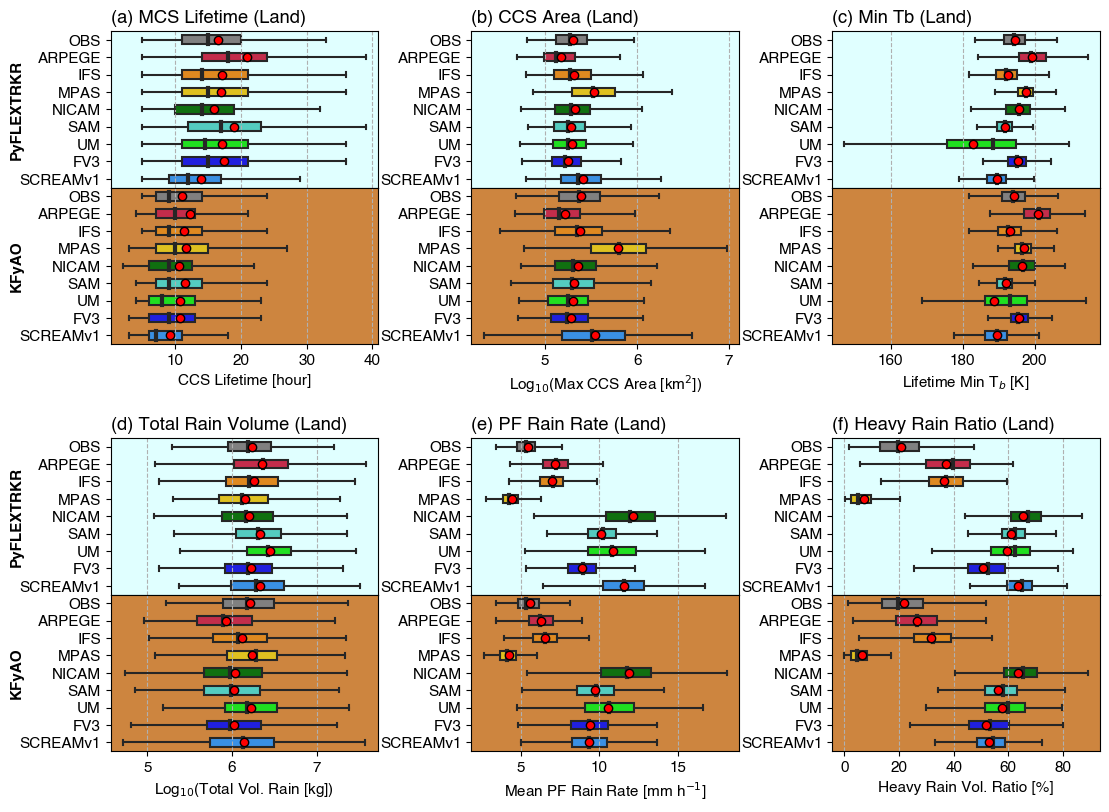

In [141]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_kfyao_l, log10maxccsarea_kfyao_l, mintb_kfyao_l, ],
    [log10pfvolrain_kfyao_l, meanpfrainrate_kfyao_l, pfhrr_kfyao_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'KFyAO']
panel_colors = {'top':'lightcyan', 'bot':'peru'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_KFyAO.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

## PyFLEXTRKR vs. DL

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

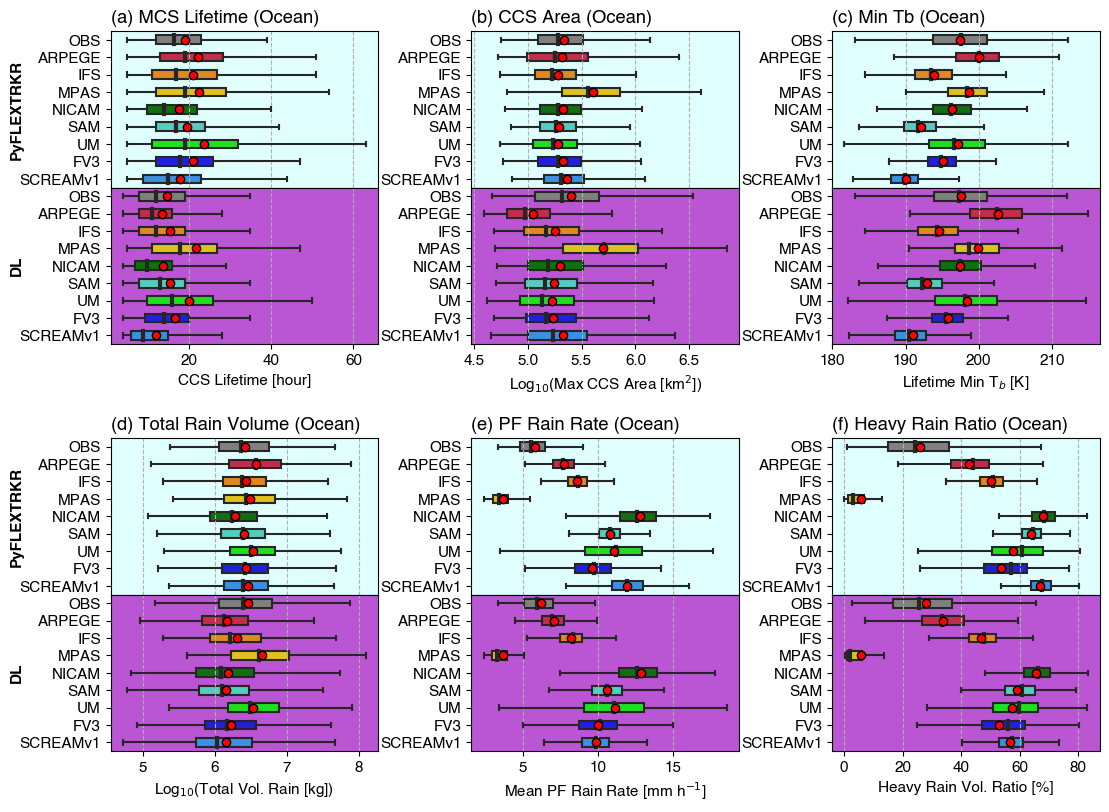

In [142]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_dl_o, log10maxccsarea_dl_o, mintb_dl_o, ],
    [log10pfvolrain_dl_o, meanpfrainrate_dl_o, pfhrr_dl_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'DL']
panel_colors = {'top':'lightcyan', 'bot':'mediumorchid'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_DL.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

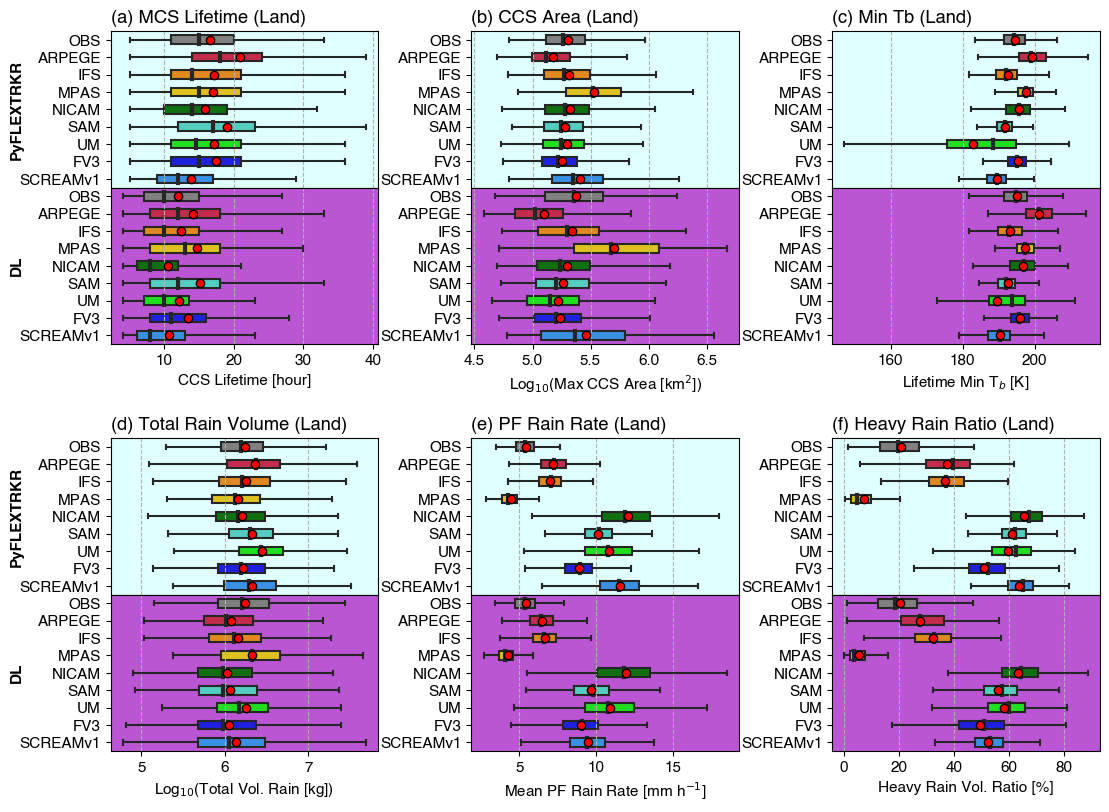

In [143]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_dl_l, log10maxccsarea_dl_l, mintb_dl_l, ],
    [log10pfvolrain_dl_l, meanpfrainrate_dl_l, pfhrr_dl_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'DL']
panel_colors = {'top':'lightcyan', 'bot':'mediumorchid'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_DL.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

## PyFLEXTRKR vs. simpleTrack

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

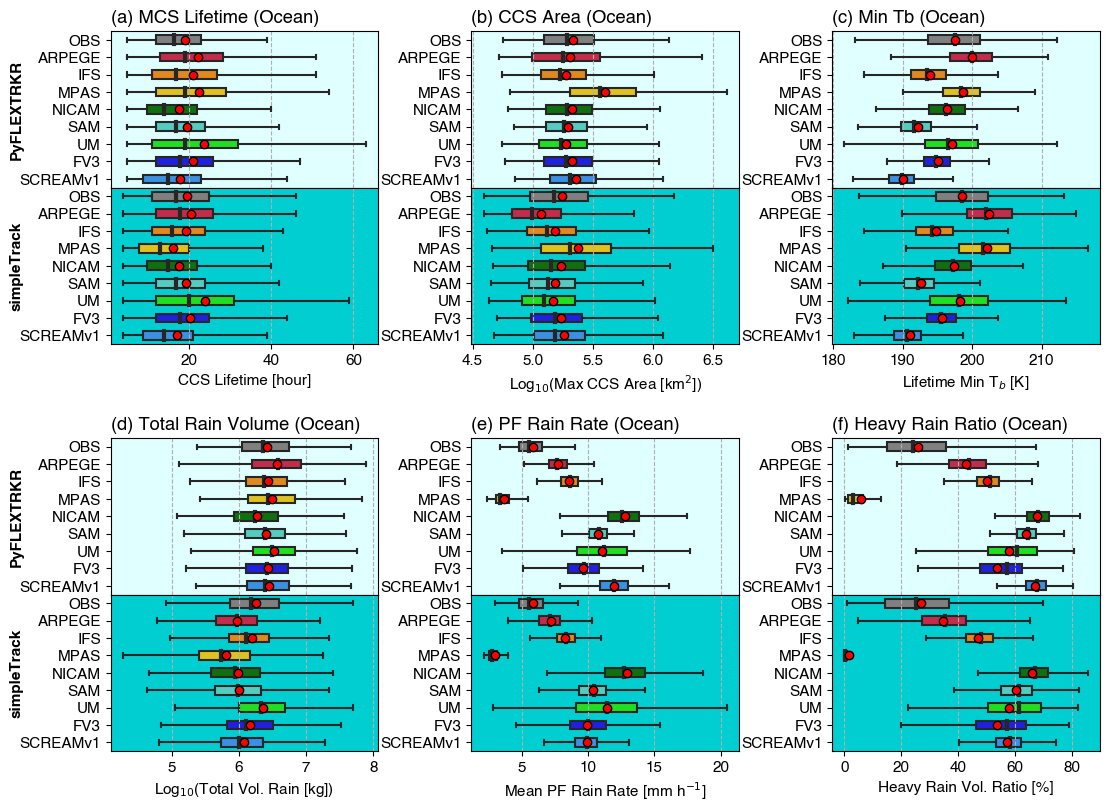

In [144]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_simtrack_o, log10maxccsarea_simtrack_o, mintb_simtrack_o, ],
    [log10pfvolrain_simtrack_o, meanpfrainrate_simtrack_o, pfhrr_simtrack_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'simpleTrack']
panel_colors = {'top':'lightcyan', 'bot':'darkturquoise'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_simpleTrack.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

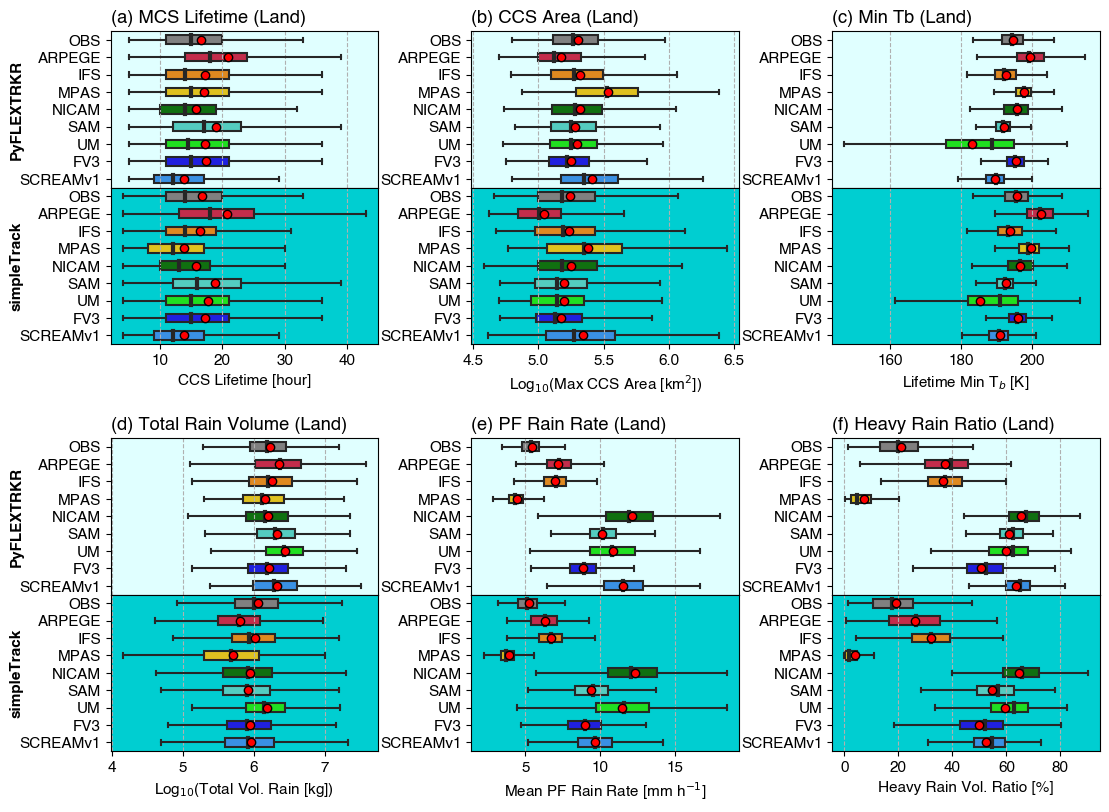

In [145]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_simtrack_l, log10maxccsarea_simtrack_l, mintb_simtrack_l, ],
    [log10pfvolrain_simtrack_l, meanpfrainrate_simtrack_l, pfhrr_simtrack_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'simpleTrack']
panel_colors = {'top':'lightcyan', 'bot':'darkturquoise'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_simpleTrack.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

## PyFLEXTRKR vs. MOAAP

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

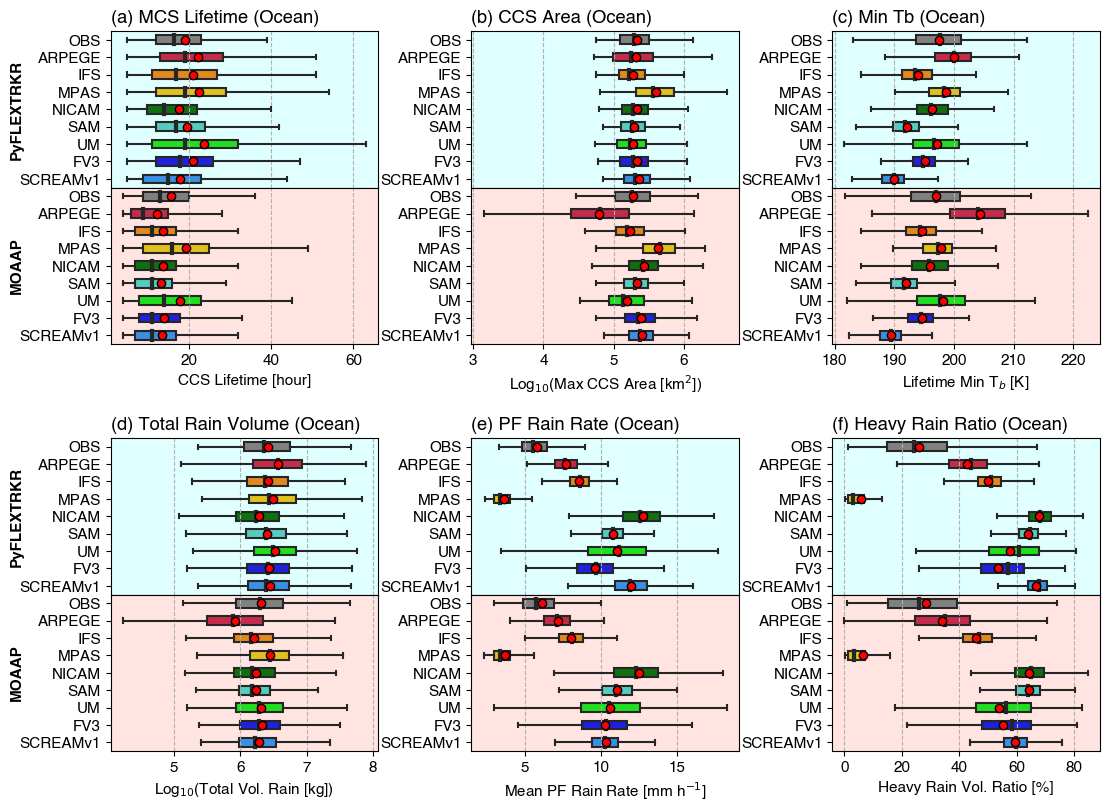

In [146]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_moaap_o, log10maxccsarea_moaap_o, mintb_moaap_o, ],
    [log10pfvolrain_moaap_o, meanpfrainrate_moaap_o, pfhrr_moaap_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'MOAAP']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_MOAAP.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

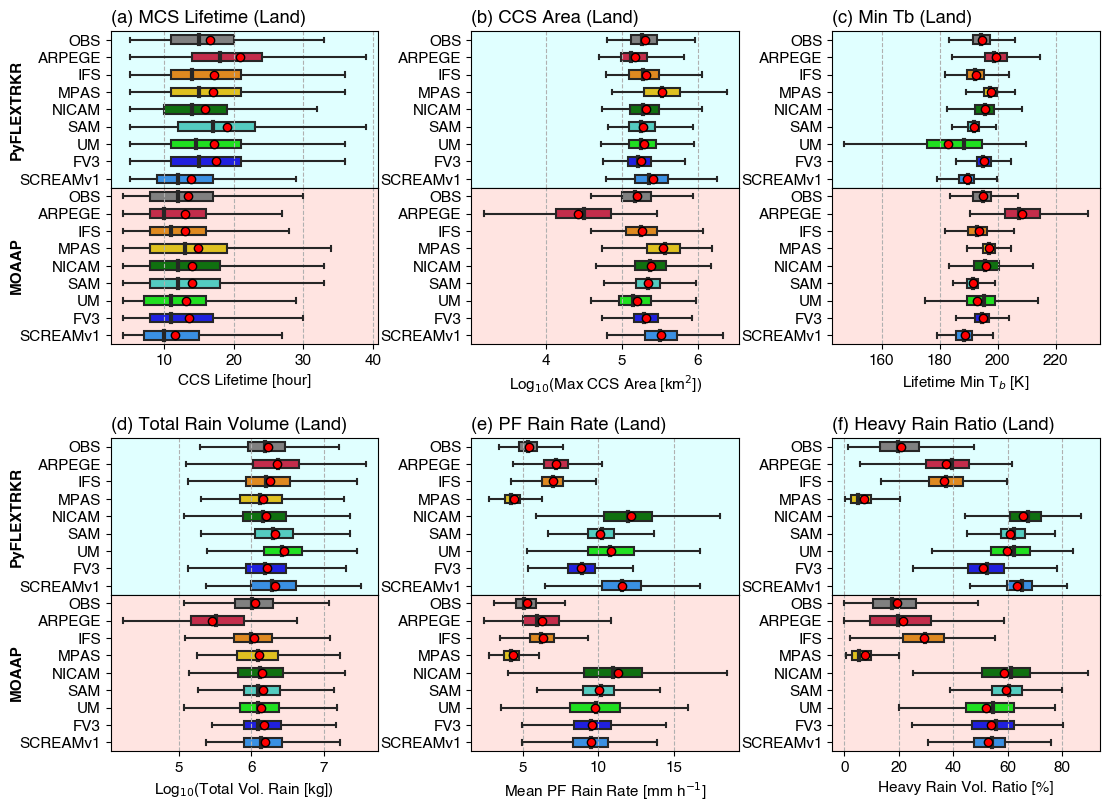

In [147]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_moaap_l, log10maxccsarea_moaap_l, mintb_moaap_l, ],
    [log10pfvolrain_moaap_l, meanpfrainrate_moaap_l, pfhrr_moaap_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'MOAAP']
panel_colors = {'top':'lightcyan', 'bot':'mistyrose'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_MOAAP.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

## PyFLEXTRKR vs. TOOCAN

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

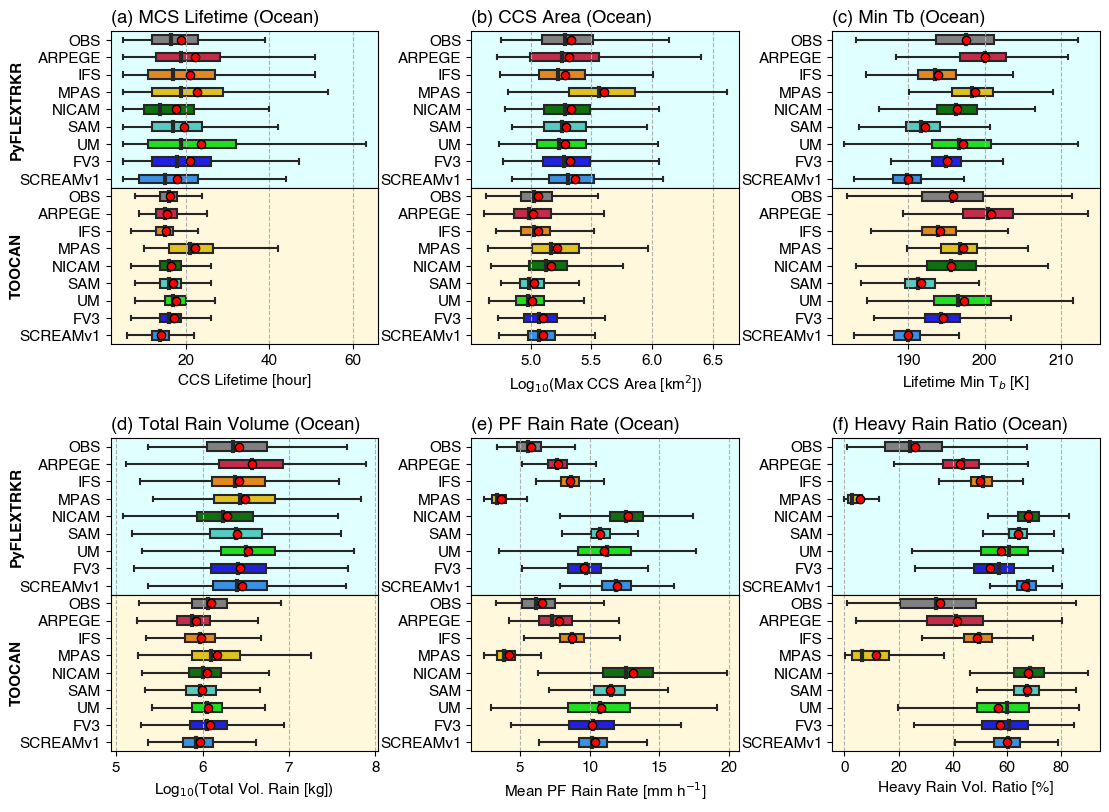

In [148]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_toocan_o, log10maxccsarea_toocan_o, mintb_toocan_o, ],
    [log10pfvolrain_toocan_o, meanpfrainrate_toocan_o, pfhrr_toocan_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'TOOCAN']
panel_colors = {'top':'lightcyan', 'bot':'cornsilk'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_TOOCAN.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

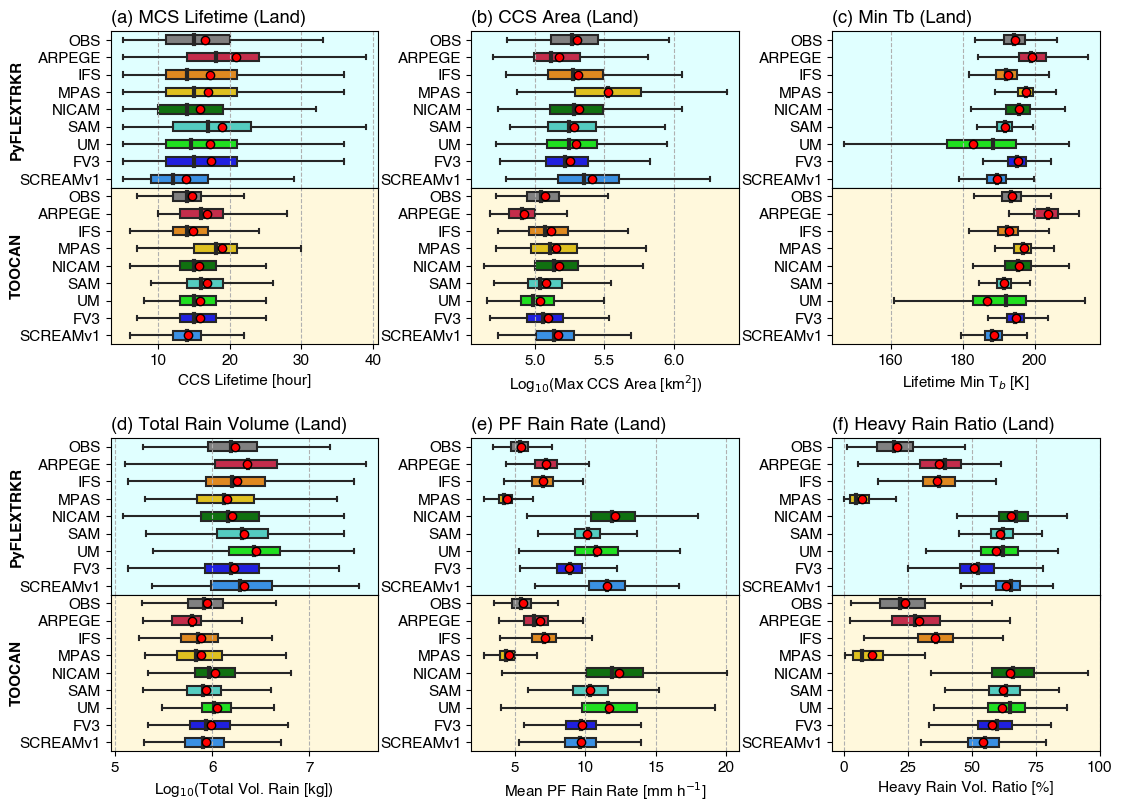

In [149]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_toocan_l, log10maxccsarea_toocan_l, mintb_toocan_l, ],
    [log10pfvolrain_toocan_l, meanpfrainrate_toocan_l, pfhrr_toocan_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'TOOCAN']
panel_colors = {'top':'lightcyan', 'bot':'cornsilk'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_TOOCAN.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

In [150]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/boxwhisker_mcs_land_2x3_PyFLEXTRKR_TOOCAN.png'

## PyFLEXTRKR vs tobac

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

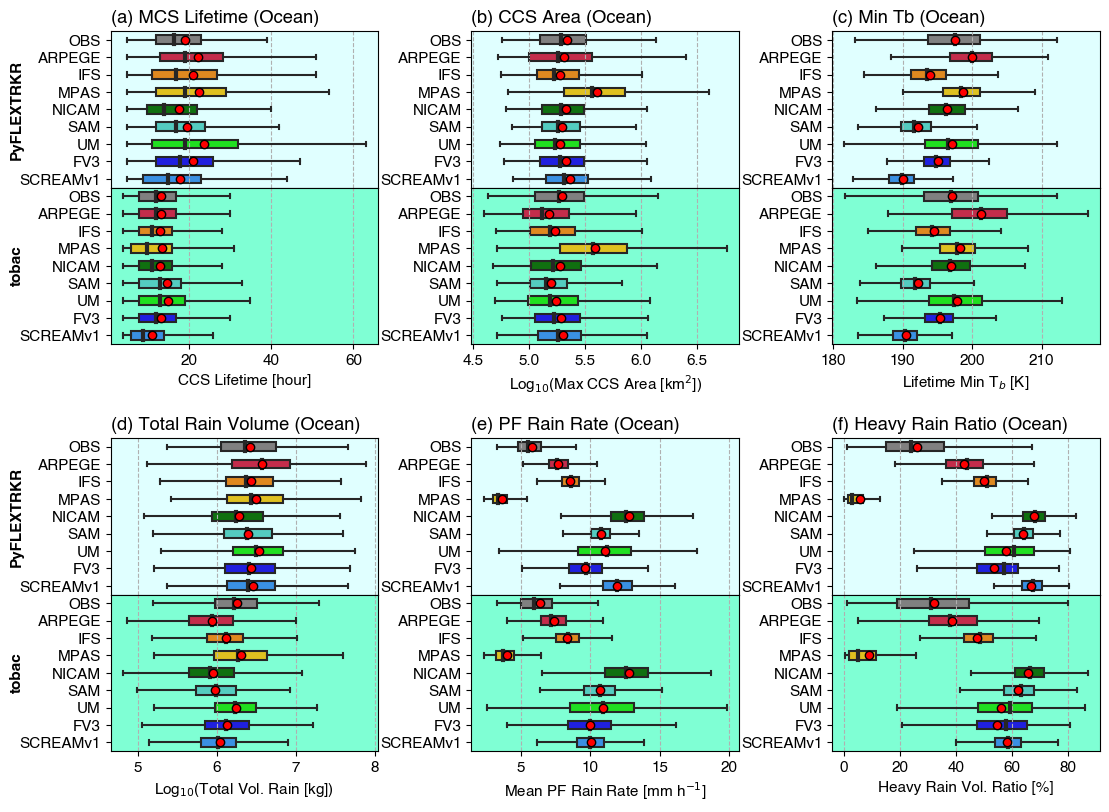

In [151]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_tobac_o, log10maxccsarea_tobac_o, mintb_tobac_o, ],
    [log10pfvolrain_tobac_o, meanpfrainrate_tobac_o, pfhrr_tobac_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'tobac']
panel_colors = {'top':'lightcyan', 'bot':'aquamarine'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_tobac.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

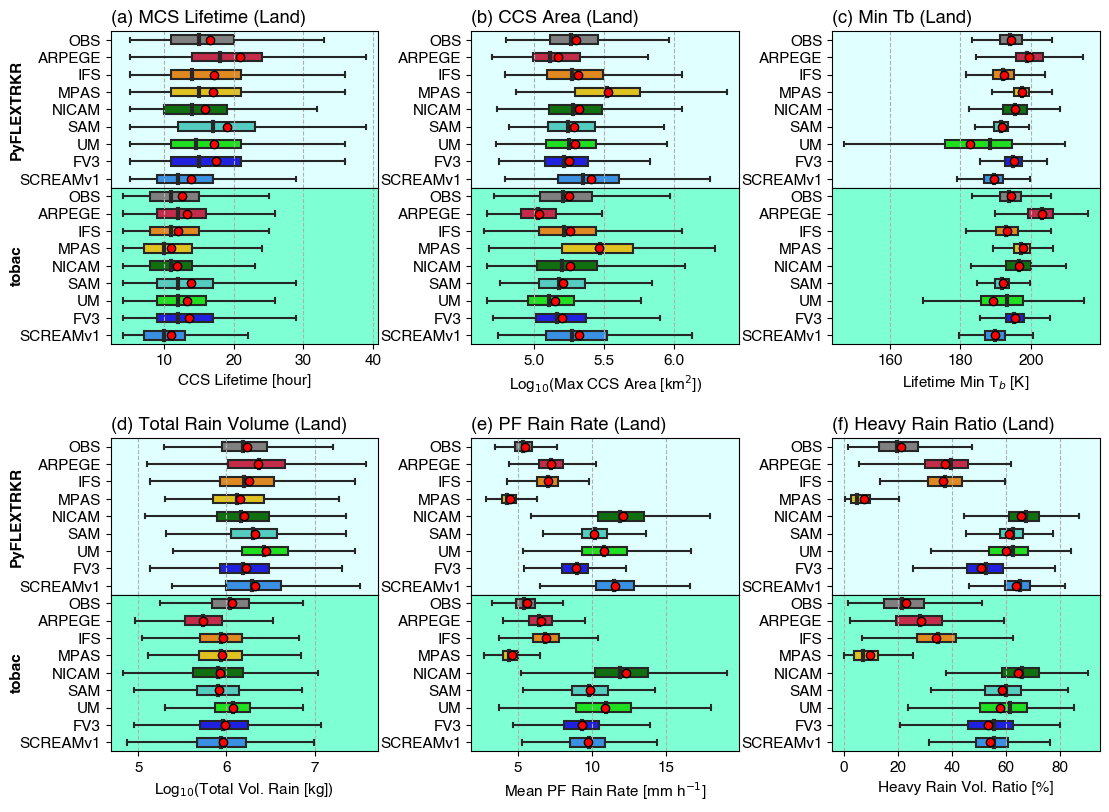

In [152]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_tobac_l, log10maxccsarea_tobac_l, mintb_tobac_l, ],
    [log10pfvolrain_tobac_l, meanpfrainrate_tobac_l, pfhrr_tobac_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'tobac']
panel_colors = {'top':'lightcyan', 'bot':'aquamarine'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_tobac.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

## PyFLEXTRKR vs TAMS

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

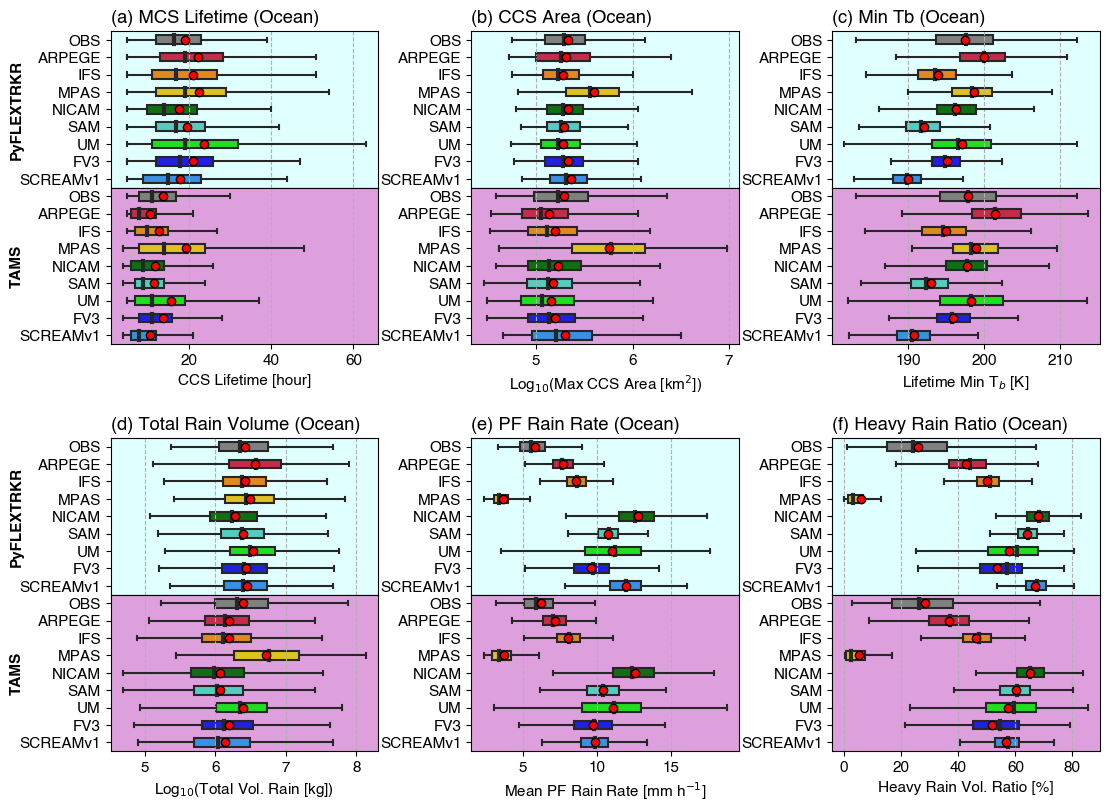

In [153]:
data_top = [
    [ccslifetime_pyflex_o, log10maxccsarea_pyflex_o, mintb_pyflex_o, ],
    [log10pfvolrain_pyflex_o, meanpfrainrate_pyflex_o, pfhrr_pyflex_o],
]
data_bot = [
    [ccslifetime_tams_o, log10maxccsarea_tams_o, mintb_tams_o, ],
    [log10pfvolrain_tams_o, meanpfrainrate_tams_o, pfhrr_tams_o],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)'],
    ['(d) Total Rain Volume (Ocean)', '(e) PF Rain Rate (Ocean)', '(f) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'TAMS']
panel_colors = {'top':'lightcyan', 'bot':'plum'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_ocean_2x3_PyFLEXTRKR_TAMS.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)

/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_top[0,col])
/tmp/ipykernel_240850/229769764.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs_bot[0,col])
/tmp/ipykernel_2

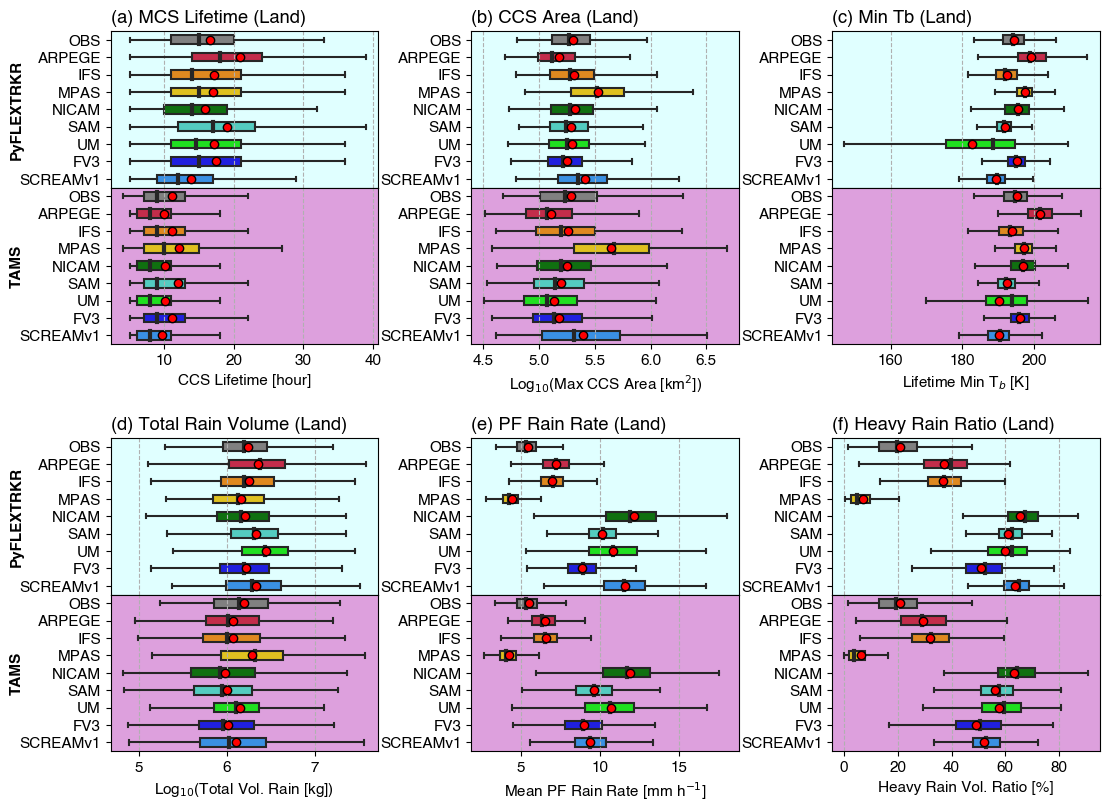

In [154]:
data_top = [
    [ccslifetime_pyflex_l, log10maxccsarea_pyflex_l, mintb_pyflex_l, ],
    [log10pfvolrain_pyflex_l, meanpfrainrate_pyflex_l, pfhrr_pyflex_l],
]
data_bot = [
    [ccslifetime_tams_l, log10maxccsarea_tams_l, mintb_tams_l, ],
    [log10pfvolrain_tams_l, meanpfrainrate_tams_l, pfhrr_tams_l],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)'],
    ['(d) Total Rain Volume (Land)', '(e) PF Rain Rate (Land)', '(f) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Lifetime Min T$_b$ [K]', ],
    ['Log$_{10}$(Total Vol. Rain [kg])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Heavy Rain Vol. Ratio [%]'],
]
legends = name_map
label_topbot = ['PyFLEXTRKR', 'TAMS']
panel_colors = {'top':'lightcyan', 'bot':'plum'}
legend_ncol = 2
figsize = [15,9]
fontsize = 11
figname = f'{figdir}boxwhisker_mcs_land_2x3_PyFLEXTRKR_TAMS.png'
fig = boxplot_mirror_mxn(2, 3, data_top, data_bot, titles, xlabels, legends, figname, panel_colors=panel_colors, 
                           # map_show=False, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0], map_bottop='bot', 
                           legend_fontsize=6, legend_loc='best', legend_ncol=legend_ncol, label_topbot=label_topbot, figsize=figsize, fontsize=fontsize)